# Particle Swarm Optimization for motif finding (TFBS)
second type of gaps

In [ ]:
import numpy as np
import random
import math

class PSOMotifPlus:
  def __init__(self, sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold):
    self.sequences = sequences
    self.motif_length = motif_length
    self.gap_length = gap_length
    self.gap_Spos_agent_dict = {}
    self.num_agents = num_agents
    self.max_iterations = max_iterations
    self.min_iterations = min_iterations
    self.stagnation_threshold = stagnation_threshold
    self.agent_initialization_strategy = 2
    self.num_bases = 4  # A, C, G, T
    self.agents = []
    self.pa = 0.25
    self.pc = 0.25
    self.pg = 0.25
    self.pt = 0.25
    self.background_frequency_list = [self.pa, self.pc, self.pg, self.pt]
    self.background_frequency = {"A": self.pa, "C": self.pc, "G": self.pg, "T": self.pt}
    self.base_dict = {"A": 0, "C": 1, "G": 2, "T": 3}

############################
  def initialize_agents(self):
    upper_bound_gap = self.motif_length - self.gap_length

    if self.agent_initialization_strategy == 1:
      for _ in range(self.num_agents):
        agent = "".join(random.choices("ACGT", k=self.motif_length))
        self.agents.append(agent)
        gap_Spos = random.randint(0, upper_bound_gap)
        gap_Spos_agent_dict[agent] = gap_Spos
    else:
      for _ in range(self.num_agents):
        sequence = random.choice(self.sequences)
        upper_bound = len(sequence) - self.motif_length
        random_position = random.randrange(0, upper_bound + 1)
        agent = sequence[random_position:random_position + self.motif_length]
        self.agents.append(agent)
        gap_Spos = random.randint(0, upper_bound_gap)
        self.gap_Spos_agent_dict[agent] = gap_Spos

  def calculate_background_frequency(self):
    count = [0] * self.num_bases
    for sequence in self.sequences:
      for i in range(len(sequence)):
        current_base = sequence[i]
        count[self.base_dict[current_base]] += 1
    for n in range(self.num_bases):
      if count[n] == 0:
        count = [num + 1 for num in count]
    count_sum = sum(count[i] for i in range (len(count)))
    count = [count[i] / count_sum for i in range (len(count))]
    self.pa = count[0]
    self.pc = count[1]
    self.pg = count[2]
    self.pt = count[3]

############################
  def calculate_matching_score(self, consensus, subsequence):
    score = 0
    gap_Spos = self.gap_Spos_agent_dict[consensus]
    for i in range(self.motif_length):
      if (i >= gap_Spos) and (i < (gap_Spos + self.gap_length)):
        continue
      xi = consensus[i]
      yi = subsequence[i]
      px = self.background_frequency[xi]
      py = self.background_frequency[yi]
      if xi == yi:
        score += 1 + math.log((0.25 / px), 4)
      else:
        score += math.log((0.25 / np.sqrt(px * py)), 4)
    return score

  def calculate_fitness(self, consensus):
    matches = []
    positions = []
    for sequence in self.sequences:
      best_score = float("-inf")
      best_match = None
      best_position = 0
      for i in range(len(sequence) - self.motif_length + 1):
        subsequence = sequence[i:i + self.motif_length]
        score = self.calculate_matching_score(consensus, subsequence)
        if score > best_score:
          best_score = score
          best_match = subsequence
          best_position = i
      matches.append(best_match)
      positions.append(best_position)
    ppm = self.calculate_ppm(matches)
    fitness = self.calculate_information_content(ppm)
    return matches, positions, fitness

  def calculate_ppm(self, matches):
    pfm = np.zeros((self.num_bases, self.motif_length))
    for match in matches:
      for i in range(self.motif_length):
        base = match[i]
        pfm[self.base_dict[base]][i] += 1
    ppm = pfm / len(matches)
    return ppm

  def calculate_information_content(self, ppm):
    information_content = 0
    for j in range(self.motif_length):
      column_Nfrequency = ppm[:, j]
      for b in range(self.num_bases):
        fb = column_Nfrequency[b]
        pb = self.background_frequency_list[b]
        if fb != 0:
          information_content += fb * np.log2(fb / pb)
    return information_content

  def update_agents(self, pbest, gbest):
    for i in range(self.num_agents):
      agent = self.agents[i]
      pbest_agent = pbest[i]
      gbest_agent = gbest
      x = ["" for _ in range(4)]
      c = [1.0, 1.0, 1.0, 1.0]
      r = [0.25, 0.25, 0.25, 0.25]
      weights = [1.0, 1.0, 1.0, 1.0]
      weighted_values = [1.0, 1.0, 1.0, 1.0]
      for j in range(self.motif_length):
        x[0] = agent[j]
        x[1] = pbest_agent[j]
        x[2] = gbest_agent[j]
        x[3] = random.choice("ACGT")

    # relative importance of the four terms
        c[0] = 0.75
        c[1] = 1.0
        c[2] = 1.25
        c[3] = 0.5
        r[0] = random.uniform(0, 1)
        r[1] = random.uniform(0, 1)
        r[2] = random.uniform(0, 1)
        r[3] = random.uniform(0, 1)
        weights[0] = (1 - (self.background_frequency[x[0]])) / 3
        weights[1] = (1 - (self.background_frequency[x[1]])) / 3
        weights[2] = (1 - (self.background_frequency[x[2]])) / 3
        weights[3] = (1 - (self.background_frequency[x[3]])) / 3
        for k in range (self.num_bases):
          weighted_values[k] = c[k] * r[k] * weights[k]
        i_star = np.argmax(weighted_values)
        x_prime = x[i_star]
        agent_list = list(agent)
        agent_list[j] = x_prime
        temp_agent = ''.join(agent_list)
        agent = temp_agent

  def optimize(self):
    self.calculate_background_frequency()
    final_consensus =  "".join(random.choices("ACGT", k=self.motif_length))
    final_consensus_fitness = -float("inf")
    final_consensus_positions = [0]*len(self.sequences)
    final_consensus_gap_Sposition = 0
    for reset in range(self.max_iterations):
      self.initialize_agents()
      pbest = self.agents.copy()
      pbest_fitness = [-float("inf") for _ in range(self.num_agents)]
      gbest = random.choice(self.agents)
      gbest_fitness = float("-inf")
      gbest_positions = [0]*len(self.sequences)
      gbest_gap_Sposition = 0
      stagnation_count = 0
      for iteration in range(self.min_iterations):
        prev_gbest = gbest
        for i in range(self.num_agents):
          consensus = self.agents[i]
          matches, positions , fitness = self.calculate_fitness(consensus)
          if fitness > pbest_fitness[i]:
            pbest[i] = consensus
            pbest_fitness[i] = fitness
          if fitness > gbest_fitness:
            gbest = consensus
            gbest_fitness = fitness
            gbest_positions = positions
            gbest_gap_Sposition = self.gap_Spos_agent_dict[gbest]

        #check shift = built in the implementation due to fitness calculating function
        self.update_agents(pbest, gbest)
        if prev_gbest == gbest:
          stagnation_count += 1
        else:
          stagnation_count = 0
        if stagnation_count >= self.stagnation_threshold:
          break
      if gbest_fitness >= final_consensus_fitness:
        final_consensus = gbest
        final_consensus_fitness = gbest_fitness
        final_consensus_positions = gbest_positions
        final_consensus_gap_Sposition = gbest_gap_Sposition

    #post processing
    return final_consensus, final_consensus_fitness, final_consensus_positions, final_consensus_gap_Sposition

In [ ]:
# sequences = ["ATGCTAGCTAGCTAGC", "AGCTAGCTAGCTAGCT", "CTAGCTAGCTAGCTAG"]
# sequences = ["CCCCCATGCACCTTCGAAA", "AAAAAAAAAATGCGGG", "TTTATGCTTTTTTAAAAA"]
# sequences = ["TTCAGCGCAACGATTCCTGCTCCTTATGCAAGGGAAATCACCATACTGACCCCGCTTCTACTTACATGAGTCTGCAGACAGGCGTCTACCCCTCGCAGG",
#              "CCTCGGGTACAACTAGATGCACATATTAAAGCGAACCGAATAGCAAACCTTGACACCAACCGACTCTTATTATGACGTGCTTGCACTACACGATTGCCG",
#              "TAAGCTAGCGAGGCAAAATTATGAAAGGATTCCGATCACCAACGAAAGAGGGCCACTATGACTTCCACCTCTTGTTAGGACTCGTACCCCCATAGACAA"]
# sequences = ["TAAGGCTAGCGAGG", "CAAAAAAAGGAT", "TCCGATCACCAAGG"]
sequences = ["AACTGATTCGAAAGCCTCTTGCACGTATAGGATTTCTGAAAAAAGCCCTCACGAGAATTACCAAATCTCCACCACAGTCCAGGGGCGGACGCTGGTCTTGCTACCCCCCCTGGAATTCTAAGTGTCGCAAGAGCGAGATGCCTAACACCTAGGTACATTATCACGGCAGAGAGGAGTATATTGCTTTTGGACTAGGTTGC",
             "GGTAACTTTGGTCATAAGGGTGACGGTGTGCCAACCACCCCCCCTGGAAGCTGAAGCAACGTATTTATCGCCACGGTGAGACTACACTAGAGCAGATGACACGATATGGTCGCATGCACCGCATCGACAAGACAAAATTTTACAAAGCCATTCTTTCTACTGCAGCCGCACAATAATGGAGCAAATTCGTGCCTCTAGCC",
             "AAATTATGACTGATTTCGATCGTGGACCCCCCCTGGAAAACCAAGGTCAGGAGGACGTTGAGCCCAAGGAGTTCGCACGAAACGTCACATACGCGTCGGTGATCCCGCGCGGCTCAACGAAGCGTTGACATAAGCCTAACCCCTCTTTAAGGAAAAGTGTTCTTAACTAACCCGACTTCGACCTTGCCGTACATCATGAA"]

motif_length = 20
gap_length = 4
num_agents = 30
max_iterations = 100
min_iterations = 10
shift_check_interval = 5
shift_threshold = 2
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus, final_consensus_fitness, final_consensus_positions, final_consensus_gap_Spositions = pso_motif_plus.optimize()

found_motifs = []
i = 0
for seq in sequences:
  found_motifs.append(seq[final_consensus_positions[i]:(final_consensus_positions[i] + motif_length)])
  i += 1

gapped_found_motifs = []
for motif in found_motifs:
  for i in range(final_consensus_gap_Spositions, (final_consensus_gap_Spositions + gap_length)):
    motif_list = list(motif)
    motif_list[i] = 'n'
    motif = ''.join(motif_list)
  gapped_found_motifs.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus)
print()
print("final consensus fitness: ", final_consensus_fitness)
print()
print("final consensus positions: ", final_consensus_positions)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions, "    gap_length: ", gap_length)
print()
print("found motifs: ", found_motifs)
print()
print("found gapped motifs: ", gapped_found_motifs)

Optimization complete.
Final consensus: ACCCCCCCTGGAAGCTGAAG

final consensus fitness:  34.32681666378205

final consensus positions:  [102, 36, 25]

final consensus gap start position:  15     gap_length:  4

found motifs:  ['ACCCCCCCTGGAATTCTAAG', 'ACCCCCCCTGGAAGCTGAAG', 'ACCCCCCCTGGAAAACCAAG']

found gapped motifs:  ['ACCCCCCCTGGAATTnnnnG', 'ACCCCCCCTGGAAGCnnnnG', 'ACCCCCCCTGGAAAAnnnnG']


# With Post Processing

In [13]:
import numpy as np
import random
import math

class PSOMotifPlus:
  def __init__(self, sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold):
    self.sequences = sequences
    self.motif_length = motif_length
    self.gap_length = gap_length
    self.gap_Spos_agent_dict = {}
    self.num_agents = num_agents
    self.max_iterations = max_iterations
    self.min_iterations = min_iterations
    self.stagnation_threshold = stagnation_threshold
    self.agent_initialization_strategy = 2
    self.num_bases = 4  # A, C, G, T
    self.agents = []
    self.pa = 0.25
    self.pc = 0.25
    self.pg = 0.25
    self.pt = 0.25
    self.background_frequency_list = [self.pa, self.pc, self.pg, self.pt]
    self.background_frequency = {"A": self.pa, "C": self.pc, "G": self.pg, "T": self.pt}
    self.base_dict = {"A": 0, "C": 1, "G": 2, "T": 3}

############################
  def initialize_agents(self):
    upper_bound_gap = self.motif_length - self.gap_length

    if self.agent_initialization_strategy == 1:
      for _ in range(self.num_agents):
        agent = "".join(random.choices("ACGT", k=self.motif_length))
        self.agents.append(agent)
        gap_Spos = random.randint(0, upper_bound_gap)
        self.gap_Spos_agent_dict[agent] = gap_Spos
    else:
      for _ in range(self.num_agents):
        sequence = random.choice(self.sequences)
        upper_bound = len(sequence) - self.motif_length
        random_position = random.randrange(0, upper_bound + 1)
        agent = sequence[random_position:random_position + self.motif_length]
        self.agents.append(agent)
        gap_Spos = random.randint(0, upper_bound_gap)
        self.gap_Spos_agent_dict[agent] = gap_Spos

  def calculate_background_frequency(self):
    count = [0] * self.num_bases
    for sequence in self.sequences:
      for i in range(len(sequence)):
        current_base = sequence[i]
        count[self.base_dict[current_base]] += 1
    for n in range(self.num_bases):
      if count[n] == 0:
        count = [num + 1 for num in count]
    count_sum = sum(count[i] for i in range (len(count)))
    count = [count[i] / count_sum for i in range (len(count))]
    self.pa = count[0]
    self.pc = count[1]
    self.pg = count[2]
    self.pt = count[3]

############################
  def calculate_matching_score(self, consensus, subsequence):
    score = 0
    gap_Spos = self.gap_Spos_agent_dict[consensus]
    for i in range(self.motif_length):
      if (i >= gap_Spos) and (i < (gap_Spos + self.gap_length)):
        continue
      xi = consensus[i]
      yi = subsequence[i]
      px = self.background_frequency[xi]
      py = self.background_frequency[yi]
      if xi == yi:
        score += 1 + math.log((0.25 / px), 4)
      else:
        score += math.log((0.25 / np.sqrt(px * py)), 4)
    return score

  def calculate_fitness(self, consensus):
    matches = []
    positions = []
    for sequence in self.sequences:
      best_score = float("-inf")
      best_match = None
      best_position = 0
      for i in range(len(sequence) - self.motif_length + 1):
        subsequence = sequence[i:i + self.motif_length]
        score = self.calculate_matching_score(consensus, subsequence)
        if score > best_score:
          best_score = score
          best_match = subsequence
          best_position = i
      matches.append(best_match)
      positions.append(best_position)
    ppm = self.calculate_ppm(matches)
    fitness = self.calculate_information_content(ppm)
    return matches, positions, fitness

  def calculate_ppm(self, matches):
    pfm = np.zeros((self.num_bases, self.motif_length))
    for match in matches:
      for i in range(self.motif_length):
        base = match[i]
        pfm[self.base_dict[base]][i] += 1
    ppm = pfm / len(matches)
    return ppm

  def calculate_information_content(self, ppm):
    information_content = 0
    for j in range(self.motif_length):
      column_Nfrequency = ppm[:, j]
      for b in range(self.num_bases):
        fb = column_Nfrequency[b]
        pb = self.background_frequency_list[b]
        if fb != 0:
          information_content += fb * np.log2(fb / pb)
    return information_content

  def update_agents(self, pbest, gbest):
    upper_bound_gap = self.motif_length - self.gap_length
    for i in range(self.num_agents):
      agent = self.agents[i]
      pbest_agent = pbest[i]
      gbest_agent = gbest

      pbest_gap_Spos = self.gap_Spos_agent_dict[pbest_agent]
      gbest_gap_Spos = self.gap_Spos_agent_dict[gbest_agent]
      y = [0]*4
      c_g = [1.0, 1.0, 1.0, 1.0]
      r_g = [0.25, 0.25, 0.25, 0.25]
      y[0] = self.gap_Spos_agent_dict[agent]
      y[1] = pbest_gap_Spos
      y[2] = gbest_gap_Spos
      y[3] = random.randint(0, upper_bound_gap)
      c_g[0] = 0.7
      c_g[1] = 0.9
      c_g[2] = 1.0
      c_g[3] = 0.4
      r_g[0] = random.uniform(0, 1)
      r_g[1] = random.uniform(0, 1)
      r_g[2] = random.uniform(0, 1)
      r_g[3] = random.uniform(0, 1)
      weighted_gap_Spos_values = [1.0]*4
      for s in range (self.num_bases):
        weighted_gap_Spos_values[s] = c_g[s] * r_g[s] * y[0]
      p_star = int(sum(weighted_gap_Spos_values) / 4)

      # pbest_gap_Spos = self.gap_Spos_agent_dict[pbest_agent]
      # gbest_gap_Spos = self.gap_Spos_agent_dict[gbest_agent]
      # y = [0]*4
      # c_g = [1.0, 1.0, 1.0, 1.0]
      # r_g = [0.25, 0.25, 0.25, 0.25]
      # y[0] = self.gap_Spos_agent_dict[agent]
      # y[1] = pbest_gap_Spos
      # y[2] = gbest_gap_Spos
      # y[3] = random.randint(0, upper_bound_gap)
      # c_g[0] = 0.75
      # c_g[1] = 1.0
      # c_g[2] = 1.25
      # c_g[3] = 0.5
      # r_g[0] = random.uniform(0, 1)
      # r_g[1] = random.uniform(0, 1)
      # r_g[2] = random.uniform(0, 1)
      # r_g[3] = random.uniform(0, 1)
      # weighted_gap_Spos_values = [1.0]*4
      # for s in range (self.num_bases):
      #   weighted_gap_Spos_values[s] = c_g[s] * r_g[s]
      # p_star = np.argmax(weighted_gap_Spos_values)

      x = ["" for _ in range(4)]
      c = [1.0, 1.0, 1.0, 1.0]
      r = [0.25, 0.25, 0.25, 0.25]
      weights = [1.0, 1.0, 1.0, 1.0]
      weighted_values = [1.0, 1.0, 1.0, 1.0]
      for j in range(self.motif_length):
        x[0] = agent[j]
        x[1] = pbest_agent[j]
        x[2] = gbest_agent[j]
        x[3] = random.choice("ACGT")

    # relative importance of the four terms
        c[0] = 0.75
        c[1] = 1.0
        c[2] = 1.25
        c[3] = 0.4

        r[0] = random.uniform(0, 1)
        r[1] = random.uniform(0, 1)
        r[2] = random.uniform(0, 1)
        r[3] = random.uniform(0, 1)
        weights[0] = (1 - (self.background_frequency[x[0]])) / 3
        weights[1] = (1 - (self.background_frequency[x[1]])) / 3
        weights[2] = (1 - (self.background_frequency[x[2]])) / 3
        weights[3] = (1 - (self.background_frequency[x[3]])) / 3
        for k in range (self.num_bases):
          weighted_values[k] = c[k] * r[k] * weights[k]
        i_star = np.argmax(weighted_values)
        x_prime = x[i_star]
        agent_list = list(agent)
        agent_list[j] = x_prime
        temp_agent = ''.join(agent_list)
        agent = temp_agent
        self.gap_Spos_agent_dict[agent] = p_star

#################################################################################

  def psuedo_count(self, matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    for j in range(cols):
      has_zero = False
      for i in range(rows):
        if matrix[i][j] == 0:
          has_zero = True
          break
      if has_zero:
        for i in range(rows):
          matrix[i][j] += 1
    return matrix

  def column_sums(self, matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    sums = [0] * cols
    for j in range(cols):
      for i in range(rows):
        sums[j] += matrix[i][j]
    return sums

  def divide_columns(self, matrix, divisor):
      rows = len(matrix)
      cols = len(matrix[0])
      for j in range(cols):
          for i in range(rows):
              matrix[i][j] /= divisor[j]
      return matrix

  def calculate_ppm_for_pp(self, matches):
    pfm = np.zeros((self.num_bases, self.motif_length))
    for match in matches:
      for i in range(self.motif_length):
        base = match[i]
        pfm[self.base_dict[base]][i] += 1
    pfm = self.psuedo_count(pfm)
    col_sum = self.column_sums(pfm)
    ppm = self.divide_columns(pfm, col_sum)
    return ppm

  def post_processing(self, final_positions):
    found_motifs = []
    i = 0
    for seq in self.sequences:
      found_motifs.append(seq[final_positions[i]:(final_positions[i] + self.motif_length)])
      i += 1
    ppm = self.calculate_ppm_for_pp(found_motifs)
    scores = []
    subseq_scores = {}
    seq_num = 0
    for seq in self.sequences:
      for i in range(len(seq) - self.motif_length + 1):
        subseq = seq[i:i + self.motif_length]
        score = 0
        for pos in range(self.motif_length):
          base = subseq[pos]
          base_num = self.base_dict[base]
          prob = ppm[base_num][pos]
          background = self.background_frequency[base]
          score += np.log2(prob/ background)
        scores.append(score)
        subseq_scores[subseq] = []
        subseq_scores[subseq].append(score)
        subseq_scores[subseq].append(i)
        subseq_scores[subseq].append(seq_num)
      seq_num += 1
    min_sc = min(scores)
    max_sc = max(scores)
    real_motifs = {}
    for sub in subseq_scores:
      for i in range(0, len(subseq_scores[sub]), 3):
        score = subseq_scores[sub][i]
        if ((score - min_sc) / (max_sc - min_sc)) > 0.6:
          real_motifs[sub] = []
          real_motifs[sub].append(score)
          real_motifs[sub].append(subseq_scores[sub][i+1])
          real_motifs[sub].append(subseq_scores[sub][i+2])
    return real_motifs

#################################################################################

  def optimize(self):
    self.calculate_background_frequency()
    final_consensus =  "".join(random.choices("ACGT", k=self.motif_length))
    final_consensus_fitness = -float("inf")
    final_consensus_positions = [0]*len(self.sequences)
    final_consensus_gap_Sposition = 0
    for reset in range(self.max_iterations):
      self.initialize_agents()
      pbest = self.agents.copy()
      pbest_fitness = [-float("inf") for _ in range(self.num_agents)]
      gbest = random.choice(self.agents)
      gbest_fitness = float("-inf")
      gbest_positions = [0]*len(self.sequences)
      gbest_gap_Sposition = 0
      stagnation_count = 0
      for iteration in range(self.min_iterations):
        prev_gbest = gbest
        for i in range(self.num_agents):
          consensus = self.agents[i]
          matches, positions , fitness = self.calculate_fitness(consensus)
          if fitness > pbest_fitness[i]:
            pbest[i] = consensus
            pbest_fitness[i] = fitness
          if fitness > gbest_fitness:
            gbest = consensus
            gbest_fitness = fitness
            gbest_positions = positions
            gbest_gap_Sposition = self.gap_Spos_agent_dict[gbest]

        #check shift = built in the implementation due to fitness calculating function
        self.update_agents(pbest, gbest)
        if prev_gbest == gbest:
          stagnation_count += 1
        else:
          stagnation_count = 0
        if stagnation_count >= self.stagnation_threshold:
          break
      if gbest_fitness >= final_consensus_fitness:
        final_consensus = gbest
        final_consensus_fitness = gbest_fitness
        final_consensus_positions = gbest_positions
        final_consensus_gap_Sposition = gbest_gap_Sposition

    real_motifs = self.post_processing(final_consensus_positions)
    return final_consensus, final_consensus_fitness, final_consensus_positions, final_consensus_gap_Sposition, real_motifs

## test

In [ ]:
# sequences = ["ATGCTAGCTAGCTAGC", "AGCTAGCTAGCTAGCT", "CTAGCTAGCTAGCTAG"]
# sequences = ["CCCCCATGCACCTTCGAAA", "AAAAAAAAAATGCGGG", "TTTATGCTTTTTTAAAAA"]
# sequences = ["TTCAGCGCAACGATTCCTGCTCCTTATGCAAGGGAAATCACCATACTGACCCCGCTTCTACTTACATGAGTCTGCAGACAGGCGTCTACCCCTCGCAGG",
#              "CCTCGGGTACAACTAGATGCACATATTAAAGCGAACCGAATAGCAAACCTTGACACCAACCGACTCTTATTATGACGTGCTTGCACTACACGATTGCCG",
#              "TAAGCTAGCGAGGCAAAATTATGAAAGGATTCCGATCACCAACGAAAGAGGGCCACTATGACTTCCACCTCTTGTTAGGACTCGTACCCCCATAGACAA"]
# sequences = ["TAAGGCTAGCGAGG", "CAAAAAAAGGAT", "TCCGATCACCAAGG"]
sequences = ["AACTGATTCGAAAGCCTCTTGCACGTATAGGATTTCTGAAAAAAGCCCTCACGAGAATTACCAAATCTCCACCACAGTCCAGGGGCGGACGCTGGTCTTGCTACCCCCCCTGGAATTCTAAGTGTCGCAAGAGCGAGATGCCTAACACCTAGGTACATTATCACGGCAGAGAGGAGTATATTGCTTTTGGACTAGGTTGC",
             "GGTAACTTTGGTCATAAGGGTGACGGTGTGCCAACCACCCCCCCTGGAAGCTGAAGCAACGTATTTATCGCCACGGTGAGACTACACTAGAGCAGATGACACGATATGGTCGCATGCACCGCATCGACAAGACAAAATTTTACAAAGCCATTCTTTCTACTGCAGCCGCACAATAATGGAGCAAATTCGTGCCTCTAGCC",
             "AAATTATGACTGATTTCGATCGTGGACCCCCCCTGGAAAACCAAGGTCAGGAGGACGTTGAGCCCAAGGAGTTCGCACGAAACGTCACATACGCGTCGGTGATCCCGCGCGGCTCAACGAAGCGTTGACATAAGCCTAACCCCTCTTTAAGGAAAAGTGTTCTTAACTAACCCGACTTCGACCTTGCCGTACATCATGAA"]

motif_length = 20
gap_length = 4
num_agents = 30
max_iterations = 100
min_iterations = 10
shift_check_interval = 5
shift_threshold = 2
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus, final_consensus_fitness, final_consensus_positions, final_consensus_gap_Spositions, real_motifs = pso_motif_plus.optimize()

found_motifs = []
i = 0
for seq in sequences:
  found_motifs.append(seq[final_consensus_positions[i]:(final_consensus_positions[i] + motif_length)])
  i += 1

gapped_found_motifs = []
for motif in found_motifs:
  for i in range(final_consensus_gap_Spositions, (final_consensus_gap_Spositions + gap_length)):
    motif_list = list(motif)
    motif_list[i] = 'n'
    motif = ''.join(motif_list)
  gapped_found_motifs.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus)
print()
print("final consensus fitness: ", final_consensus_fitness)
print()
print("final consensus positions: ", final_consensus_positions)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions, "    gap_length: ", gap_length)
print()
print("found motifs: ", found_motifs)
print()
print("found gapped motifs: ", gapped_found_motifs)
print()
print("real motifs: ", real_motifs)

Streaming output truncated to the last 5000 lines.
  0.14285714 0.14285714 0.14285714 0.28571429 0.42857143 0.28571429
  0.14285714 0.14285714]
 [0.28571429 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714 0.14285714 0.14285714 0.14285714 0.57142857 0.57142857
  0.14285714 0.14285714 0.28571429 0.14285714 0.14285714 0.28571429
  0.14285714 0.14285714]
 [0.28571429 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714 0.14285714 0.14285714 0.57142857 0.14285714 0.14285714
  0.14285714 0.14285714 0.28571429 0.28571429 0.28571429 0.28571429
  0.14285714 0.14285714]]
base:  A base num:  0 pos:  9 ppm:  [[0.14285714 0.57142857 0.14285714 0.14285714 0.14285714 0.14285714
  0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
  0.57142857 0.57142857 0.28571429 0.28571429 0.14285714 0.14285714
  0.57142857 0.57142857]
 [0.28571429 0.14285714 0.57142857 0.57142857 0.57142857 0.57142857
  0.57142857 0.57142857 0.57142857 0.14285714 0.14285714 0.14285

## Avarage Performance Measure Functions

In [14]:
def precision(c, p):
  return c / p

def recall(c, t):
  return c / t

def F_score(precision, recall):
  return (2 * precision * recall) / (precision + recall)

def performance_measure(c, p, t):
  prec = precision(c, p)
  rec = recall(c, t)
  F_s = F_score(prec, rec)
  return [prec, rec, F_s]

In [ ]:
def filter_df(df):
  scores = df.iloc[0, 1:]
  q1 = np.percentile(scores, 25)
  q2 = np.percentile(scores, 50)
  q3 = np.percentile(scores, 75)
  iqr = q3 - q1
  cut_off = q1 = iqr
  filtered_df = df.loc[:, df.columns[1:][scores >= cut_off]]
  return filtered_df

## CREB

In [ ]:
CREB_sequences = ["GGGTCGAAAACTTGCATCAGTCTACATCTGTCGTCCATGGAAAGTGACGTCAGGGTATAGATGGTC",
                  "TGCACTCTGAGCCGGATAACGCCGCTCCGCCCCATCAAACGGGGTGACGTCAAAACCA",
                  "CTTCACTTGGTGACGTTGCGTCACGCTAGTCGGCGCCCTCAAGTAAAATCCGCTGACATCACCCTGTGACGTACTGACATCA",
                  "TGACGCAATCCTGTGACGAGGCCTGCTGCCATTGGTCGAGAGGCTAAACTCGATTTGACGTCAGCTTGCATCAA",
                  "GCCGAAACATGACACGACAGGGTTTTTGACGCAAGCATTCTATGCCCGGTCGGTGGATGATGTCAT",
                  "CTGCCTGAGAACCTTTACGTGACCGTCGGTGCTACTAGAGATGTCAATCC"]

motif_length = 8
gap_length = 0
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(CREB_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_CREB, final_consensus_fitness_CREB, final_consensus_positions_CREB, final_consensus_gap_Spositions_CREB, real_motifs_CREB = pso_motif_plus.optimize()

found_motifs_CREB = []
i = 0
for seq in CREB_sequences:
  found_motifs_CREB.append(seq[final_consensus_positions_CREB[i]:(final_consensus_positions_CREB[i] + motif_length)])
  i += 1

gapped_found_motifs_CREB = []
for motif in found_motifs_CREB:
  for i in range(final_consensus_gap_Spositions_CREB, (final_consensus_gap_Spositions_CREB + gap_length)):
    motif_list = list(motif)
    motif_list[i] = 'n'
    motif = ''.join(motif_list)
  gapped_found_motifs_CREB.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_CREB)
print()
print("final consensus fitness: ", final_consensus_fitness_CREB)
print()
print("final consensus positions: ", final_consensus_positions_CREB)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_CREB, "    gap_length: ", gap_length)
print()
print("found motifs: ", found_motifs_CREB)
print()
print("found gapped motifs: ", gapped_found_motifs_CREB)
print()
print("real motifs: ", real_motifs_CREB)

Optimization complete.
Final consensus: GTGACGTT

final consensus fitness:  10.989178072288219

final consensus positions:  [43, 43, 9, 12, 25, 18]

final consensus gap start position:  0     gap_length:  0

found motifs:  ['GTGACGTC', 'GTGACGTC', 'GTGACGTT', 'GTGACGAG', 'TTGACGCA', 'GTGACCGT']

found gapped motifs:  ['GTGACGTC', 'GTGACGTC', 'GTGACGTT', 'GTGACGAG', 'TTGACGCA', 'GTGACCGT']

real motifs:  {'CTGTCGTC': [4.490496196848639, 27, 0], 'GTGACGTC': [9.882813619627399, 43, 1], 'GTCAGGGT': [2.6831412747910344, 48, 0], 'ATAACGCC': [2.905533696127482, 15, 1], 'GTGACGTT': [9.882813619627399, 9, 2], 'GTTGCGTC': [4.2681037755121904, 14, 2], 'GTCACGCT': [5.490496196848638, 19, 2], 'GCGCCCTC': [2.6831412747910344, 32, 2], 'CTGACATC': [4.712888618185087, 73, 2], 'GTGACGTA': [8.882813619627399, 65, 2], 'GTGACGAG': [7.297851118906243, 12, 3], 'GAGAGGCT': [2.6831412747910344, 37, 3], 'TTGACGTC': [8.297851118906243, 54, 3], 'GTCAGCTT': [2.6831412747910344, 59, 3], 'GACACGAC': [2.6831412747910

In [ ]:
import pandas as pd
df_CREB = pd.DataFrame(real_motifs_CREB)
df_CREB

,CTGTCGTC,GTGACGTC,GTCAGGGT,ATAACGCC,GTGACGTT,GTTGCGTC,GTCACGCT,GCGCCCTC,CTGACATC,GTGACGTA,GTGACGAG,GAGAGGCT,TTGACGTC,GTCAGCTT,GACACGAC,TTGACGCA,ATGATGTC,TTTACGTG,GTGACCGT,GAGATGTC
0,4.490496,9.882814,2.683141,2.905534,9.882814,4.268104,5.490496,2.683141,4.712889,8.882814,7.297851,2.683141,8.297851,2.683141,2.683141,5.712889,4.490496,4.490496,6.712889,4.268104
1,27.000000,43.000000,48.000000,15.000000,9.000000,14.000000,19.000000,32.000000,73.000000,65.000000,12.000000,37.000000,54.000000,59.000000,10.000000,25.000000,56.000000,13.000000,18.000000,37.000000
2,0.000000,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000


In [ ]:
filtered_df_CREB = filter_df(df_CREB)
filtered_df_CREB

,GTGACGTC,GTGACGTT,GTTGCGTC,GTCACGCT,CTGACATC,GTGACGTA,GTGACGAG,TTGACGTC,TTGACGCA,ATGATGTC,TTTACGTG,GTGACCGT,GAGATGTC
0,9.882814,9.882814,4.268104,5.490496,4.712889,8.882814,7.297851,8.297851,5.712889,4.490496,4.490496,6.712889,4.268104
1,43.000000,9.000000,14.000000,19.000000,73.000000,65.000000,12.000000,54.000000,25.000000,56.000000,13.000000,18.000000,37.000000
2,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,5.000000,5.000000


In [ ]:
c_CREB = 7
p_CREB = 13
t_CREB = 12

In [ ]:
CREB_accuracy = performance_measure(c_CREB, p_CREB, t_CREB)
CREB_accuracy

[0.5384615384615384, 0.5833333333333334, 0.5599999999999999]

## CRP

In [ ]:
CRP_sequences = ["TAATGTTTGTGCTGGTTTTTGTGGCATCGGGCGAGAATAGCGCGTGGTGTGAAAGACTGTTTTTTTGATCGTTTTCACAAAAATGGAAGTCCACAGTCTTGACAG",
                  "GACAAAAACGCGTAACAAAAGTGTCTATAATCACGGCAGAAAAGTCCACATTGATTATTTGCACGGCGTCACACTTTGCTATGCCATAGCATTTTTATCCATAAG",
                  "ACAAATCCCAATAACTTAATTATTGGGATTTGTTATATATAACTTTATAAATTCCTAAAATTACACAAAGTTAATAACTGTGAGCATGGTCATATTTTTATCAAT",
                  "CACAAAGCGAAAGCTATGCTAAAACAGTCAGGATGCTACAGTAATACATTGATGTACTGCATGTATGCAAAGGACGTCACATTACCGTGCAGTACAGTTGATAGC",
                  "ACGGTGCTACACTTGTATGTAGCGCATCTTTCTTTACGGTCAATCAGCATGGTGTTAAATTGATCACGTTTTAGACCATTTTTTCGTCGTGAAACTAAAAAAACC",
                  "AGTGAATTATTTGAACCAGATCGCATTACAGTGATGCAAACTTGTAAGTAGATTTCCTTAATTGTGATGTGTATCGAAGTGTGTTGCGGAGTAGATGTTAGAATA",

                  "GCGCATAAAAAACGGCTAAATTCTTGTGTAAACGATTCCACTAATTTATTCCATGTCACACTTTTCGCATCTTTGTTATGCTATGGTTATTTCATACCATAAGCC",
                  "GCTCCGGCGGGGTTTTTTGTTATCTGCAATTCAGTACAAAACGTGATCAACCCCTCAATTTTCCCTTTGCTGAAAAATTTTCCATTGTCTCCCCTGTAAAGCTGT",
                  "AACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCAC",
                  "ACATTACCGCCAATTCTGTAACAGAGATCACACAAAGCGACGGTGGGGCGTAGGGGCAAGGAGGATGGAAAGAGGTTGCCGTATAAAGAAACTAGAGTCCGTTTA",
                  "GGAGGAGGCGGGAGGATGAGAACACGGCTTCTGTGAACTAAACCGAGGTCATGTAAGGAATTTCGTGATGTTGCTTGCAAAAATCGTGGCGATTTTATGTGCGCA",
                  "GATCAGCGTCGTTTTAGGTGAGTTGTTAATAAAGATTTGGAATTGTGACACAGTGCAAATTCAGACACATAAAAAAACGTCATCGCTTGCATTAGAAAGGTTTCT",

                  "GCTGACAAAAAAGATTAAACATACCTTATACAAGACTTTTTTTTCATATGCCTGACGGAGTTCACACTTGTAAGTTTTCAACTACGTTGTAGACTTTACATCGCC",
                  "TTTTTTAAACATTAAAATTCTTACGTAATTTATAATCTTTAAAAAAAGCATTTAATATTGCTCCCCGAACGATTGTGATTCGATTCACATTTAAACAATTTCAGA",
                  "CCCATGAGAGTGAAATTGTTGTGATGTGGTTAACCCAATTAGAATTCGGGATTGACATGTCTTACCAAAAGGTAGAACTTATACGCCATCTCATCCGATGCAAGC",
                  "CTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATATGCGGTGTGAAATACCGCACAGATGCGTAAGGAGAAAATACCGCATCAGGCGCTC",
                  "CTGTGACGGAAGATCACTTCGCAGAATAAATAAATCCTGGTGTCCCTGTTGATACCGGGAAGCCCTGGGCCAACTTTTGGCGAAAATGAGACGTTGATCGGCACG",
                  "GATTTTTATACTTTAACTTGTTGATATTTAAAGGTATTTAATTGTAATAACGATACTCTGGAAAGTATTGAAAGTTAATTTGTGAGTGGTCGCACATATCCTGTT"]

motif_length = 20
gap_length = 4
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(CRP_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_CRP, final_consensus_fitness_CRP, final_consensus_positions_CRP, final_consensus_gap_Spositions_CRP, real_motifs_CRP = pso_motif_plus.optimize()

found_motifs_CRP = []
i = 0
for seq in CRP_sequences:
  found_motifs_CRP.append(seq[final_consensus_positions_CRP[i]:(final_consensus_positions_CRP[i] + motif_length)])
  i += 1

gapped_found_motifs_CRP = []
for motif in found_motifs_CRP:
  for i in range(final_consensus_gap_Spositions_CRP, (final_consensus_gap_Spositions_CRP + gap_length)):
    motif_list = list(motif)
    motif_list[i] = 'n'
    motif = ''.join(motif_list)
  gapped_found_motifs_CRP.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_CRP)
print()
print("final consensus fitness: ", final_consensus_fitness_CRP)
print()
print("final consensus positions: ", final_consensus_positions_CRP)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_CRP, "    gap_length: ", gap_length)
print()
print("found motifs: ", found_motifs_CRP)
print()
print("found gapped motifs: ", gapped_found_motifs_CRP)
print()
print("real motifs: ", real_motifs_CRP)

Optimization complete.
Final consensus: TTCTGTAACAGAGATCACAC

final consensus fitness:  11.48065310673621

final consensus positions:  [60, 54, 46, 62, 29, 6, 41, 21, 8, 13, 28, 40, 47, 0, 16, 50, 4, 75]

final consensus gap start position:  7     gap_length:  4

found motifs:  ['TTTTTTGATCGTTTTCACAA', 'TTATTTGCACGGCGTCACAC', 'ATAAATTCCTAAAATTACAC', 'GTATGCAAAGGACGTCACAT', 'TTCTTTACGGTCAATCAGCA', 'TTATTTGAACCAGATCGCAT', 'TAATTTATTCCATGTCACAC', 'ATCTGCAATTCAGTACAAAA', 'TAATGTGAGTTAGCTCACTC', 'TTCTGTAACAGAGATCACAC', 'TTCTGTGAACTAAACCGAGG', 'AATTGTGACACAGTGCAAAT', 'ATGCCTGACGGAGTTCACAC', 'TTTTTTAAACATTAAAATTC', 'TGTTGTGATGTGGTTAACCC', 'TGCGGTGTGAAATACCGCAC', 'GACGGAAGATCACTTCGCAG', 'TAATTTGTGAGTGGTCGCAC']

found gapped motifs:  ['TTTTTTGnnnnTTTTCACAA', 'TTATTTGnnnnGCGTCACAC', 'ATAAATTnnnnAAATTACAC', 'GTATGCAnnnnACGTCACAT', 'TTCTTTAnnnnCAATCAGCA', 'TTATTTGnnnnAGATCGCAT', 'TAATTTAnnnnATGTCACAC', 'ATCTGCAnnnnAGTACAAAA', 'TAATGTGnnnnAGCTCACTC', 'TTCTGTAnnnnAGATCACAC', 'TTCTGTGnnnnAAACCGAGG', 

In [ ]:
import pandas as pd
df_CRP = pd.DataFrame(real_motifs_CRP)
df_CRP

,GTTTTTTTGATCGTTTTCAC,TTTTTTGATCGTTTTCACAA,AAAAGTGTCTATAATCACGG,TTATTTGCACGGCGTCACAC,GGATTTGTTATATATAACTT,TGTTATATATAACTTTATAA,TTATATATAACTTTATAAAT,ATAAATTCCTAAAATTACAC,AAATTCCTAAAATTACACAA,AAATTACACAAAGTTAATAA,...,GACGGAAGATCACTTCGCAG,AAATGAGACGTTGATCGGCA,ATACTTTAACTTGTTGATAT,TAACTTGTTGATATTTAAAG,ATATTTAAAGGTATTTAATT,TATTTAAAGGTATTTAATTG,GTATTTAATTGTAATAACGA,TAATTGTAATAACGATACTC,TAATTTGTGAGTGGTCGCAC,ATTTGTGAGTGGTCGCACAT
0,2.242267,15.516922,2.563502,15.186774,6.271321,2.260189,3.10407,2.956513,4.496387,2.785894,...,3.137333,3.737531,1.978539,1.942013,6.255379,2.486686,6.856283,2.200932,13.794456,7.045653
1,58.000000,60.000000,16.000000,54.000000,25.000000,30.000000,32.00000,46.000000,48.000000,57.000000,...,4.000000,83.000000,7.000000,13.000000,23.000000,24.000000,33.000000,38.000000,75.000000,77.000000
2,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,...,16.000000,16.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000


In [ ]:
filtered_df_CRP = filter_df(df_CRP)
filtered_df_CRP

,TTTTTTGATCGTTTTCACAA,TTATTTGCACGGCGTCACAC,GGATTTGTTATATATAACTT,AACTGTGAGCATGGTCATAT,GTATGCAAAGGACGTCACAT,TGGTGTTAAATTGATCACGT,TTATTTGAACCAGATCGCAT,AATTGTGATGTGTATCGAAG,TTGTGTAAACGATTCCACTA,TAATTTATTCCATGTCACAC,...,AATTGTGACACAGTGCAAAT,ATGCCTGACGGAGTTCACAC,TAATTTATAATCTTTAAAAA,GATTGTGATTCGATTCACAT,TGTTGTGATGTGGTTAACCC,TGCGGTGTGAAATACCGCAC,ATATTTAAAGGTATTTAATT,GTATTTAATTGTAATAACGA,TAATTTGTGAGTGGTCGCAC,ATTTGTGAGTGGTCGCACAT
0,15.516922,15.186774,6.271321,9.800541,12.696901,6.357051,18.646205,8.045653,10.604144,15.879345,...,9.837067,9.675704,6.289937,10.916018,9.746093,8.234194,6.255379,6.856283,13.794456,7.045653
1,60.000000,54.000000,25.000000,75.000000,62.000000,49.000000,6.000000,59.000000,23.000000,41.000000,...,40.000000,47.000000,25.000000,70.000000,16.000000,50.000000,23.000000,33.000000,75.000000,77.000000
2,0.000000,1.000000,2.000000,2.000000,3.000000,4.000000,5.000000,5.000000,6.000000,6.000000,...,11.000000,12.000000,13.000000,13.000000,14.000000,15.000000,17.000000,17.000000,17.000000,17.000000


In [ ]:
c_CRP = 19
p_CRP = 24
t_CRP = 37

In [ ]:
CRP_accuracy = performance_measure(c_CRP, p_CRP, t_CRP)
CRP_accuracy

[0.7916666666666666, 0.5135135135135135, 0.6229508196721311]

## E2F

In [16]:
E2F_sequences = ["GGGTGACCACTGAGGGAGTGTTCCACAGTAATGTTGTCTGGTCGCTAGATGGCGCGGGTGAGGCCACGCTTTGCGAAAACGAAAGTGCTTGAAAAGGCGCGGGATAGCGTGCGCTACCGGATGGCGGGTAATACATGCTATCCTTACATTTTGGCATTTTGGGCAGCTGGGAGGCGGCGGATGGGGGTGCTTCTTTTCGC",
                  "CAGAGCTTCTCATTGGCCTGCACGCAGTGGTGGGGCCCAAGCTGAGATGAGCGGTTACGGAAAAGCCCGCGCTGGCTGCTGCGCGAACCTGCTTTTTCGCGCCAAAGTCACAAAGCGGGTGGTGGCGGGAAAATCAAGGGTTTTTCCGCAGTGCCAGGAACACTGTTCCAGGGACTCTTTGCTCACTAAACCTGTTGGCC",
                  "CGCGCGGGCTCCGCCCCTCGTGTCTTGTACGCTTCGCCCCTTCCGTATGCTCCGCCCCTGCGCTCGCGCGCCAGGGCCGGGCGGCGCCGACGCACTTGGCGGGAGATAGGAAAGTGGTTCTGTGCGCTCCCTAGGCAGCTGCAGTTCCTGGGAACGTGCGACCAGACCTGCAGACACGCTGACGCCTGAGAGCACCGCCT",
                  "AGCGACGGATGTGGCAAAAGTGACGTTTTTGGTGTGCGCCGGTGTACACAGGAAGTGACAATTTTCGCGCGGTTTTAGGCGGATGTTGTAGTAAATTTGGGCGTAACCGAGTAAGATTTGGCCATTTTCGCGGGAAAACTGAATAAGAGGAAGTGAAATCTGAATAATTTTGTGTTACTCATAGCGCGTAATATTTGTCT",
                  "TCCCAGCCCGCGCACCGACCAGCGCCCCAGTTCCCCACAGACGCCGGCGGGCCCGGGAGCCTCGCGGACGTGACGCCGCGGGCGGAAGTGACGTTTTCCCGCGGTTGGACGCGGCGCTCAGTTGCCGGGCGGGGGAGGGCGCGTCCGGTTTTTCTCAGGGGACGTTGAAATTATTTTTGTAACGGGAGTCGGGAGAGGAC",
                  "TGCTCAGTTTCCTTTGGTTTACCCTTCACTCGCCCTGACCCTGTCGCCTTGAATGACGTCAAGGCCGCGAGCGCTTTCATTGGTCCATTTCAATAGTCGCGGGATACTTGAACTGCAAGAACAGCCGCCGCTCCAGCGGGCTGCTCGCTGCATCTCTGGGCGTCTTTGGCTCGCCACGCTGGGCAGTGCCTGCCTGCGCC",

                  "GGCGAGGGACGGGGCGGGACGGGCTCTGGGTCCCGCGCGGCCGCTGAGGGGCTGGGAGCCGCGGCGGGGCGGTGCGAGGGCGGGCCGGGGCCGGTTCCGCGCGCAGGGATTTTAAATGTCCCGCTCTGAGCCGGGCGCAGGAGCAGCCGGCGCGGCCGCCAGCGCGGTGTAGGGGGCAGGCGCGGATCCCGCCACCGCCG",
                  "GGGTCCGGCGCGTTAAAGCCAATAGGAACCGCCGCCGTTGTTCCCGTCACGGCCGGGGCAGCCAATTGTGGCGGCGCTCGGCGGCTCGTGGCTCTTTCGCGGCAAAAAGGATTTGGCGCGTAAAAGTGGCCGGGACTTTGCAGGCAGCGGCGGCCGGGGGCGGAGCGGGATCGAGCCCTCGCCGAGGCCTGCCGCCATGG",
                  "TCTCCAGGCGGCTCCTTTCCAGCGCCCGACCGCTTCTTTCTCCTGCTCTCCTCCGGCTTCCCCTCAGCTCTAGCTTTTCCCTAAGGGGTCATCACAGGCGCCAAACGCGCGTCCGCGGGAAGGCCGGGGGCGGAGCGCGGCGCGGCGCGGCACGTCAGTGGCCTTCCGGCCGGAAGTCCGCAGCCTCCCGAGCCGCTGAT",
                  "CCGCGAGCCGCTTTCTTCTTCCCCTCTCATTGGCCCAGCCTAGCTGCCATTCGGTTGAGAGGAGGAGAAGTTGCTTACTGATTGGTGGATTCCGTTTGGCGCCAACTAGGAAAGGGGGGCGGGGCAGCAGCTGGCCCCACTGAGCCGCTATTACCGCGAAAGGCCGGCCTGGCTGCGACAGCCTGGGTAAGAGGTGTAGG",
                  "AGGGGGAGAGGAGAAGAGGGGAGGAGGGAGGGGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGTCGGAAAAAAAAGAGAAAAGCAAATGGCTTTTGGCGCGAAAGGCTTTGGCGCCTCCCCTGATTTTTATGGAAATCAAGAGGGCGGGGAAAAGCCTCTTGCCTCTGCCTTTCTCCCTCCCCCTCGTCTGCGCCACA",
                  "GCGGGCGCGAGCACGCCGCGACCCTGCGTGCGCCGGGGCGGGGGGGCGGGGCCTCGCCTGCACAAATAGGGACGAGGGGGCGGGGCGGCCACAATTTCGCGCCAAACTTGACCGCGCGTTCTGCTGTAACGAGCGGGCTCGGAGGTCCTCCCGCTGCTGTCATGGTTGGTTCGCTAAACTGCATCGTCGCTGTGTCCCAG",

                  "TTAATATCAATATAGTCCAATCAAAACACGTATATTCAGAAAGCTCATTTGCATTAAGAGGAAGCTGCAAGCTTAGCCAATGGCCCAGCTTCTTTTTCGCGCCCAGCAGCTGCTATAAAATGCGCGTCCCTGTAGGTTCCTTTCACTCACTTTCTGACTTAGGCCACAGGTCGTTTTACCATGTCTGGACGTGGCAAGCA",
                  "GGGACTGCTAGGAGCTCCGGAGGAAAAACGGACTTTTTTTGAGGAGAAAAGCGGAGGCAGACGGTGGATGACAACACGTCCCGCAGCTGCAGATTTTCGCGCGCTTTGGCGCAGGTGGTTGTGGGTAGCGCGCCTGGGAGGGAGAAAGAAGTCGGGGGCCGTGGCGCGCAGCCCGCGGGGCCTGAAGGGATGTTCGAGGA",
                  "TCGCAGTCGTGCTCCAGCTCAGTACGATTAGGGCTGCCGCTTACCGCGCCCGCCTGCTCTCCAGCGCCCCGCTCAGCGAGCCACGTGGACCAACTTCGGCGCGCGGTGTTCGCTTGGTTCCAGTGGGGCTCGCCGCGCCTCCCGCTTCTCGGTGCTCGCCTCGTCTCAGCTCCGACCCCATGGCGGCTCTGGTGTTGGAG",
                  "GGCGCCCGCCCTCCTGCTTTTTCTCTAGCCGCCCTTTCCTCTTTCTTTCGCGCTCTAGCCACCCGGGAAGGCACTGCGGTAGCTGGGCTCTGATTGGCTGCTTTGAAAGTCTACGGGCTACCCGATTGGTGAATCCGGGGCCCTTTAGCGCGGTGAGTTTGAAACTGCTCGCACTTGGCTTCAAAGCTGGCTCTTGGAAA",
                  "GACCCCCGAGCTGTGCTGCTCGCGGCCGCCACCGCCGGGCCCCGGCCGTCCCTGGCTCCCCTCCTGCCTCGAGAAGGGCAGGGCTTCTCAGAGGCTTGGCGGGAAAAAGAACGGAGGGAGGGATCGCGCTGAGTATAAAAGCCGGTTTTCGGGGCTTTATCTAACTCGCTGTAGTAATTCCAGTGAGAGGCAGAGGGAGC",
                  "GCTGTAACTCTTCCACTGGATTGGTAGCAAAAAAAGAGGCGGTGCCCAAGGCGAAAGGCTCTGTGACTACAGCCAATCAGAATCGAGGCCGGGCTTTGGCGGGAGGTGGGAACGCTGTGGCCATTCGGATTTGGCGCGAGCGCGGCTGGAGTTTGCTGCTGCCGCTGTGCAGTTTGTTCAGGGGCTTGTGGCGGTGAGTC",

                  "CCAGCAGGGCTCCTTCTACAACTACGGGCCGAAAGCCAGGACCAAAGCGTGTGTCTCACTAGAAATGAAAAGAAGGTGGAAGGAGAAAAGAAAACTTCGCGCCAATCGGCGTGGCCCCGCCCCCAGACCGTCCCTTCGTTGCGACACCAACTAGCTCGCCCCGCCCACTCCGTACACCTAAGAGGGGCGCATGACGTACA",
                  "GGGCCCATGGCGCCAATCCGCGCGCCGCAGGCCCTCCTGGCTCGGTGCGCTGTCCAATCAGAGGGGAGAGGGGGCGGGACCCAGAGGGAGGTTTTTTGCCGCGAAAAGACCACGTGGGGACGCGGTGGGGCGGGTCTGGCGGGGGCGGGGCACCTCTGTGCAGGGTTCCCAGTCACCGCGACGCTCCTCGGGAAGCCATA",
                  "CTATGAAAACCGGACTACAGGGGCAACTCCGCCGCAGGGCAGGCGCGGCGCCTCAGGGATGGCTTTTGGGCTCTGCCCCTCGCTGCTCCCGGCGTTTGGCGCCCGCGCCCCCTCCCCCTGCGCCCGCCCCCGCCCCCCTCCCGCTCCCATTCTCTGCCGGGCTTTGATCTTTGCTTAACAACAGTAACGTCACACGGACT",
                  "CCGATCAGCCACGTCCATCGCCCTGATTTCCAGGCCCTCCCAGTCCCTGGGCGCACGTCCCGGATTCCTCCCACGAGGGGGCGGGCTGCGGCCAAATCTCCCGCCAGGTCAGCGGCCGGGGCTGATTGGCCCCCATGGCGGCGGGGCCGGCTCGTGATTGGCCAGCACGCCGTGGTTTAAAGCGGTCGGCGGGAACCAGG",
                  "CCTGACCCCAGCGGCGGGAAACGCGCAGTGATTCAAAACCAGTGTAGCTTTATTGGCTGCGACAGCGGACATTCATTGTCCGGCCCGCCCCGCGCTTCCCGCCAAAACGCCCGCGGCGCATGCCGGCCGCGCTCAGCCCGGGGAGCGCGCTCTCCCGGCGACCCACGCGCGCACTTCCCGCCTGCAGGCTGAGTGCCTCC",
                  "ATCAGCTTCGGCGCACGCTGGAAGACGCGGAGGCTCTCTTCAGCAAATACTGCGCGCTGACTCTTAAGGACTAGTTTCGCGCCCTTTCTCAAATTTAAGCGCGAAAACTACGTCATCTCCAGCGGCCACACCCGGCGCCAGCACCTGTCGTCAGCGCCATTATGAGCAAGGAAATTCCCACGCCCTACATGTGGAGTTAC",

                  "TTTGTTGTCGCGCCGTAGCGTTTAAATTTCGCGCGCTCTACACGGATTGGCCATTTCCACGGGTGAGCAGCCTCCGGCTTGCGGCCACTCCGCCTTGTCTTCTTCCCCGGGTAAAAGGTTTTCAAATTGGACCAATCACTGGGCGCGTTCTCTCAGCTAAGGCGCGTCACCGAAGGGTTAATTGCAACCAACCAGAGGTG"]

motif_length = 12
gap_length = 2
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(E2F_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_E2F, final_consensus_fitness_E2F, final_consensus_positions_E2F, final_consensus_gap_Spositions_E2F, real_motifs_E2F = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_E2F)
print()
print("final consensus fitness: ", final_consensus_fitness_E2F)
print()
print("final consensus positions: ", final_consensus_positions_E2F)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_E2F, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_E2F)

Optimization complete.
Final consensus: GGATTTGGCGCG

final consensus fitness:  11.057987676987594

final consensus positions:  [44, 89, 91, 59, 91, 161, 91, 108, 12, 91, 91, 91, 89, 91, 91, 140, 91, 126, 91, 91, 91, 1, 49, 3, 23]

final consensus gap start position:  0     gap_length:  2

real motifs:  {'AATGTTGTCTGG': [1.128155624171398, 29, 0], 'TGTCTGGTCGCT': [0.15087570067148137, 34, 0], 'CTAGATGGCGCG': [7.5984755589514315, 44, 0], 'AGATGGCGCGGG': [2.384303644419951, 46, 0], 'ACGCTTTGCGAA': [0.2695201971701, 65, 0], 'TGAAAAGGCGCG': [2.469192542006464, 89, 0], 'GGATAGCGTGCG': [3.0217335650352433, 101, 0], 'CCGGATGGCGGG': [3.6915849633429128, 116, 0], 'CATTTTGGCATT': [1.4956647533676564, 146, 0], 'GCATTTTGGGCA': [4.121269238586158, 153, 0], 'CATTTTGGGCAG': [0.30301967542525987, 154, 0], 'ATTTTGGGCAGC': [0.5952004269185711, 155, 0], 'CTCATTGGCCTG': [0.6509429788455672, 8, 1], 'TCATTGGCCTGC': [-0.2197676792489096, 9, 1], 'GGCCTGCACGCA': [-0.2705880677667958, 14, 1], 'GAAAAGCCCGCG': [0

In [17]:
df_E2F = pd.DataFrame(real_motifs_E2F)
df_E2F

,AATGTTGTCTGG,TGTCTGGTCGCT,CTAGATGGCGCG,AGATGGCGCGGG,ACGCTTTGCGAA,TGAAAAGGCGCG,GGATAGCGTGCG,CCGGATGGCGGG,CATTTTGGCATT,GCATTTTGGGCA,...,CCATTTCCACGG,CATTTCCACGGG,GCCTCCGGCTTG,CGGCTTGCGGCC,TCTTCTTCCCCG,CTTCTTCCCCGG,TTCTTCCCCGGG,TCACTGGGCGCG,CGCGTTCTCTCA,AGCTAAGGCGCG
0,1.128156,0.150876,7.598476,2.384304,0.26952,2.469193,3.021734,3.691585,1.495665,4.121269,...,1.265659,3.265659,0.051481,3.373268,0.932235,1.280159,5.587587,7.639118,1.05134,6.829088
1,29.000000,34.000000,44.000000,46.000000,65.00000,89.000000,101.000000,116.000000,146.000000,153.000000,...,50.000000,51.000000,69.000000,74.000000,97.000000,98.000000,99.000000,135.000000,143.00000,154.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000,24.000000


In [32]:
filtered_df_E2F = filter_df(df_E2F)
filtered_df_E2F

,GCACTTGGCGGG,AATTTTCGCGCG,CATTTTCGCGGG,CGTTTTCCCGCG,GTCTTTGGCTCG,CGGTTCCGCGCG,CTCTTTCGCGGC,GGATTTGGCGCG,TCCTTTCCAGCG,CCGTTTGGCGCC,...,TTCTTTCGCGCT,CCCTTTAGCGCG,AGGCTTGGCGGG,GGCTTTGGCGGG,AAACTTCGCGCC,TTTTTTGCCGCG,GCGTTTGGCGCC,AGCTTCGGCGCA,TAGTTTCGCGCC,AAATTTCGCGCG
0,9.446472,13.02816,10.250552,12.002625,10.695337,10.606696,8.402555,15.320942,8.002625,11.66559,...,8.5952,10.735979,8.469193,11.958372,9.346336,11.646481,11.66559,8.606696,10.372808,13.876157
1,91.000000,59.00000,122.000000,91.000000,161.000000,91.000000,91.000000,126.000000,12.000000,91.00000,...,42.0000,140.000000,91.000000,91.000000,91.000000,91.000000,91.00000,3.000000,71.000000,23.000000
2,2.000000,3.00000,3.000000,4.000000,5.000000,6.000000,7.000000,17.000000,8.000000,9.00000,...,15.0000,15.000000,16.000000,17.000000,18.000000,19.000000,20.00000,23.000000,23.000000,24.000000


In [33]:
c_E2F = 17
p_E2F = 27
t_E2F = 27

In [34]:
E2F_accuracy = performance_measure(c_E2F, p_E2F, t_E2F)
E2F_accuracy

[0.6296296296296297, 0.6296296296296297, 0.6296296296296297]

## ERE

In [ ]:
ERE_sequences = ["AGGCTTATGCCAACCCAAGAGTGTCCTCCCCCGATCATGAAGGAATTGCGCAGTAGATGGCTTGGCCTTGATGGCAGTAGCATTGCTCCCCTTGGTCCAGATGACCCAGCCAACCCTGCATTTTAGGGGCTCGCTGGCCAACTCCTAACTAAATAAGTTTCTTTGCACATATGGGTTTTAACTTTCTTTTCTAAAACAGG",
                  "CTCAGCTTCTTCTGGGGTGACAGGAGACACACTTGCTTCTGTTGGTCTGGGCTGCCCAAATGCCTTGGTTCAAAGAGAAGACGCAGGTGGCTAGGTCACCATGCCCTCGGGGGCAGGCACCCCTTACCACACCCCCGCACAAGACTCCGGGCTCTCCCTCCCCCCGAGGGACCCATTGTGTGAGTTCAGTTTCAATAGGG",
                  "ACAAACTCCCAACTTTCCGGCCCTCAAGGGGTGACCAAGGAAGTTGCTCCACTTGGCTTTCCACAAACAGCCTGTGCCCCACCAGGCTCAGGAGGGCAGCTTGACCAATCTCTATTTCCAAGACCTTTGGCCAGTCCTATTGATCTGGACTCCTGGATAGGCAGCTGGACCAACGGACGGACGCCATGAGGGCTCTGCTG",
                  "GACAGCTAAAGAGATAAAGATTCTGGTTCCGACCAGACGTTTTGGGGAGCCTCAGGACATGGCACTATTGTGGATCCCCACTAGATTCTGCAAGAGCACCCTGCCCTCTGGGCACTGCCTGGAAGAATCAGGAGCCTGGCCATCAAGCTCTCTCCTCCACTTCTGAGGAGCCTAGGAGGCCTCCACAGGGGTCCTGGCAA",
                  "AGGTAGCAGGAGCTCCAGAGAGAAGTCAAGGAAGAGAGAGAGAGAGAGACCGGTCAGAGAGCGTCGCTGGCGAGCGAACAGAGAGAGGGACAGGGGCAAAGTGACTGACCTGCTTTTGGGGGTGACCGCCAGAGCGCGCGTGACGCTCCCCCTTGGGATCTTTCATCGGACCAGTCGCGCTGACGGACAGACAGACAGAC",
                  "GTCTGTAAAGACTATAAAAGAGCTCCTCGTCGGCTCTTCATCAGACCTCACCTGTTCCTGTCTGACTCTGGCAGCACTCACTGACAGCAAGCAGGTCAGGGTGATCTTAACATGCCTCTCTAGCTTGTGCGGACCCTGGGGGTGGAACCTAGGGCTTCCAATAGGCTAAGCAAGCACTCTACTAACATCTGTGTTCCCTA",

                  "GCCTAGCCGCGCACTTCCCGCCCTCCCACCTTCCTTTCGCCCTTCCACCAGACCTCCCTCGACGCCCGACAGCTGCTCTGGGTACTGTTTCCGGGTCAGGGTGACCTCTGGGGTGAGGAAACTGCGACTGGGAGCGGGACCCTGGCGTGCAGCATTCGCCATGCTCCGCTCACGCGTGGGAGACTGGGCTGTGGGGTACC",
                  "TCAGCAACTTCATTATTATTCACCATAATGACATCATTTAGGAAATCTCTAAAACATGAGTGGAACTTTGGAGTGCATTAAAAAATGCATTTTTGTCACTATGTCCTAGAGTGCTTTGGGGTCAGAAGAGGCAGGCAGATAGATCATGAGGTCATAACGATTTATTTATCTATATCTTCCAGGTTATTGGAGATAAGTGG",
                  "GGCTGGGACCAGCCATCTCGGTGACAGTTCCAGAACCCCTGGCCTGGGCTGCTGGGTTCAATGGAAAAAGGCTGTGACTAGAGTCAGGGGGATGGTCTCAGTGACCTCAAGGATAAGGCCAGATCCTTGCACTGTCAGTGACCCAAAGCAACAGGTGTCCAGAGCAGCAGTGTGGCGCCTTCACGCCCCCACACATCAGC",
                  "GACGTCATTTAGGAATTAAAATAGTCCAACGGGTCTCAAGTGAAAGTCTTAGTGCATACATACTGACGTGTGAACATGTGTAACTGTACACAAGGTCAGAAAGACCATTATCTATTTGCTTGTCAGGGAGATGCAAAGTGCCATGTCTATCCCTTAAGAGAAATTATCAACACACACATCAGAAAACAGACATTTGAAAC",
                  "CTGCTGAGACAAGGTGAAAGCTAAAACCCACCTGCCCTAACTGGCTCCTAGGCACCTTCAAGGTCATCTGCTGAAGAAGATAGCAGTCTCACAGGTCAAGGCGATCTTCAAGTAAAGACCCTCTGCTCTGTGTCCTGCCCTCTAGAAGGCACTGAGACCAGAGACTGGGACAGGGCTCAGGGGGCTTGCGAGACTCCTAG",
                  "TCGCCCCCACATTGATGGTTTTCAAACAGCAAACTTTTCAGCTAAAGCTTCAAACCATGATTGGAATCAGCCTGTGTTGGATTTGTGATTCAGGGTCATGGTGACCCTGATCCAGTTTGGGTGGAAATCCTTCCTAAGTATCATAAGAAGCATCTTGGCAGAGATGCTTTGGTGGCAGCCATGAGCTTTGCTGGAGGCCT",

                  "CCCCAAACCCCCACCCTCTGTGCCCTCAGGGGGGCACCCCCATCGGGGCGGGAGGGGGGGGTCAGCTGTGCCCCGGTCGCCGAGTGGCGAGGAGGTGACGGTAGCCGCCTTCCTATTTCCGCCCGGCGGGCAGCGCTGCGGGGCGAGTGCCAGCAGAGAGGCGCTCGGTCCTCCCTCCGCCCTCCCGCGCCGGGGGCAGG",
                  "CAGCGTACGGTGGTCACTGAGGCTTCTTTTTGTGTACCTGCTCACCTGGCGGGGGCTGGCCTGGCGTGGAAGTTTGGTCTGGCTCACTGCAGGGGTCAAGGTGACCCCCGGGGTCACTTGTCTAAAAGGGATGGTTTGTGGGGGTCCCCAGTGTGACCCGAGTCAGAGGTCCGGCCTTCTCCCTCAATTCGAAGACATCT",
                  "TTCCCCCTCCCTGTGCCCCTATATCACCGGCACCCCCTCCTCCTTCCCTTTTCCCTCCTCCCAGGAGACAGGGGAGGAGAAAAGGGGATCTCGGGTCGTCATGACTGAGCTGCAGGCAAAGGATCCGCGGACTCTCCACACATCTGGCGCCGCGCCCTCCCCCACCCACGTCGGGTCTCCCTTGCTTGCACGCTTGGACC",
                  "TTCTCCCTGTCCCACCCTAGTGGCCCAGGCCACCCCGGCCTGCTCCCTTCCGCAAGGCACCTCACCTTCTGTGCCCAGACCATTAGCCAACGCGGTGACCTTGACCCCGGCCCAGGCCCTGCTAATGAAGAGGAAAGCCCGTACGCACTCGGCCTGACCCACGGCGACCCTCTGTGACCAATCATACTACCAACCTCTTA",
                  "ATTGAGGGAAATTGCTGCATTCCCATTCTCAGTCCATGCCTCCACAGAGGCTATGCCAGCTGTAGGCCAGACCCTGGCAAGATCTGGGTGGATAATCAGACTGACTGGTCCCACTCTTCCCACAGGCCTCAGAGCCCCAACTTTGTTCCCTGGGGCAGCCTGGAAATAGCCAGGTCAGAAACCAGCTAGGAATTTTTCCA",
                  "TGCCTTGACTAATGAGTGATGACCTGCTCTTTGAAAAACAGAACACAATTACCTTATTCAATGATAAGCTGGCTGTTGTGAATGCGCCTCTTAGGTCAGTAAGACCTCAGGTTGGGGTGAACTTGGATGAGGCATCATCCTACACTTTAGTTTCCACCTCTGTAAGATAGGAGTACCCACTGACCTAGCAGTGAGGTTCC",

                  "TGCCTCAGCCTCCCAAGTAGCTGGGATTTCAGGCGTGCACCACCACACCCGGCTAATTTTGTATTTTTAGTAGAGATGGGCTTTCACCATGTTGGTCAGGCTGATCTCAAAATCCTGACCTCAGGTGATCCGCCCACCTCAGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGCACCTGGCCTATTTAACCATT",
                  "TACAATTTCATTATTAAAACAATTCCACTGTAAAAGAATTAGCTTAGGCCTAGACGGAATGGGCTTCATGAGCTCCTTCCCTTCCCCCTGCAAGGTCACGGTGGCCACCCCGTGAGCCACTGTTGTCACGGCCAAGCCTTTTTCCGGCCATCTCTCACTATGAATCACTTCTGCAGTGAGTACAGTATTTACCCTGGCGG",
                  "GATGGAAACGACCTTCTACGACGATGCCCTCAACGCCTCGTTCCTCCAGTCCGAGAGTGGCGCCTACGGCTACAGTAACCCTAAGATTCTGAAGCAGAGCATGACCTTGAACCTGGCCGACCCGGTGGGCAATCTGAAGCCGCACCTCCGAGCCAAGAACTCGGACCTTCTCACGTCGCCCGACGTCGGGCTGCTCAAGC",
                  "TGGCTCGGCCGTGGTGAGAGATGGTGCGGTGCCCGTTCTCCGCCCGGGTGCGAGCAGTGGGCGGTTGTTAGGGCGACCGTTCGTGACGTAGGCCGTCAGGCTGAGCAGCCTCCCGCCGATTGGCTAGGGGATCGGACGATCCTTCCTTATTGGCGGCCGGTTGGCGGCCGGAGCGTGCGTAACGGCAGTTCCTTCCGCCC",
                  "CTGAGAGAGACAAGACCGAGAAGGAGCTGAGGGGGCCCCCGGCTTACCTTCTGCTGTAGTACCCAGAACAACGGCAGCTTCTTCCCCCGGCCGGGTCACGATGCCCTATTTATAGCTGAGGGGTGGGGATGGAGCTGTTCCCAGGCTGCCTGTGCACAGGCTGGAGAGGAGGGTTACATCACTTGGCCAGACCACAGGCT",
                  "TCCCTGGGGCCAACATGTCCATGGGGTGAGTAACCTGAGGGCATGTTCCCCAGCAGCATGAATGCAGCTGCACCCTGCCCTGGACTCTCCCAGGGTCAGGGCCACCTGGTGAACACAGACCTTTCTCTGTTGGACCCACTTTGTAGTGGAAGAACACTAAGGTCTGGAGAACCCCCCACCGCAGATGTCTTGGACCTCAT",

                  "CACCACCCCGCCCCCCGCCCGGGCGCTGTGCGTGCCCGAGGTTGCCCCGCCCAGGCCAGGCCCCGCTCCGCCCCGCCCCGCGCACGCCGGCCGCGCCCACGTGACCGGTCCGGGTGCAAACACGCGGGTCAGCTGATCCGGCCCAACTGCGGCGTCATCCCGGCTATAAGCGCACGGCCTCGGCGACCCTCTCCGACCCG"]

motif_length = 20
gap_length = 4
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(ERE_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_ERE, final_consensus_fitness_ERE, final_consensus_positions_ERE, final_consensus_gap_Spositions_ERE, real_motifs_ERE = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_ERE)
print()
print("final consensus fitness: ", final_consensus_fitness_ERE)
print()
print("final consensus positions: ", final_consensus_positions_ERE)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_ERE, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_ERE)

Optimization complete.
Final consensus: CCCTCGGGGGCAGGCACCCC

final consensus fitness:  10.768950823861472

final consensus positions:  [87, 103, 86, 86, 177, 131, 139, 121, 125, 86, 139, 110, 20, 45, 16, 15, 117, 86, 86, 86, 26, 95, 86, 31, 46]

final consensus gap start position:  3     gap_length:  4

real motifs:  {'CAACCCAAGAGTGTCCTCCC': [0.7417579182747913, 10, 0], 'ACCCAAGAGTGTCCTCCCCC': [1.3449552371497302, 12, 0], 'CTCCCCCGATCATGAAGGAA': [0.5475325425339923, 25, 0], 'TCCCCTTGGTCCAGATGACC': [7.728486741427769, 86, 0], 'CCCCTTGGTCCAGATGACCC': [6.838769849812691, 87, 0], 'TGGTCCAGATGACCCAGCCA': [3.0976519328036773, 92, 0], 'CCAGATGACCCAGCCAACCC': [7.490846546392384, 96, 0], 'ATTTTAGGGGCTCGCTGGCC': [5.787380430481337, 119, 0], 'TCTGGGGTGACAGGAGACAC': [2.4534796939278998, 10, 1], 'TTCTGTTGGTCTGGGCTGCC': [5.209554111041811, 36, 1], 'TCTGTTGGTCTGGGCTGCCC': [3.7783916472540824, 37, 1], 'ACGCAGGTGGCTAGGTCACC': [1.9091591777040886, 80, 1], 'CGCAGGTGGCTAGGTCACCA': [2.662671080750178, 81,

In [ ]:
df_ERE = pd.DataFrame(real_motifs_ERE)
df_ERE

,CAACCCAAGAGTGTCCTCCC,ACCCAAGAGTGTCCTCCCCC,CTCCCCCGATCATGAAGGAA,TCCCCTTGGTCCAGATGACC,CCCCTTGGTCCAGATGACCC,TGGTCCAGATGACCCAGCCA,CCAGATGACCCAGCCAACCC,ATTTTAGGGGCTCGCTGGCC,TCTGGGGTGACAGGAGACAC,TTCTGTTGGTCTGGGCTGCC,...,CCGCCCCGCGCACGCCGGCC,CCCGCGCACGCCGGCCGCGC,CCGCGCACGCCGGCCGCGCC,CGTGACCGGTCCGGGTGCAA,ACACGCGGGTCAGCTGATCC,CCCAACTGCGGCGTCATCCC,CCAACTGCGGCGTCATCCCG,AGCGCACGGCCTCGGCGACC,CGGCCTCGGCGACCCTCTCC,CTCGGCGACCCTCTCCGACC
0,0.741758,1.344955,0.547533,7.728487,6.83877,3.097652,7.490847,5.78738,2.45348,5.209554,...,8.325281,6.477284,0.536428,0.835495,0.442841,2.838002,0.554209,4.839848,4.274713,2.59192
1,10.000000,12.000000,25.000000,86.000000,87.00000,92.000000,96.000000,119.00000,10.00000,36.000000,...,72.000000,76.000000,77.000000,99.000000,119.000000,141.000000,142.000000,168.000000,174.000000,178.00000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,1.00000,1.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.00000


In [ ]:
filtered_df_ERE = filter_df(df_ERE)
filtered_df_ERE

,CCAGATGACCCAGCCAACCC,GTGGCTAGGTCACCATGCCC,CCCTCGGGGGCAGGCACCCC,CTCAGGAGGGCAGCTTGACC,CCTGGATAGGCAGCTGGACC,TCTGCAAGAGCACCCTGCCC,CGCTGACGGACAGACAGACA,GCAAGCAGGTCAGGGTGATC,GTTTCCGGGTCAGGGTGACC,CCCTGGCGTGCAGCATTCGC,...,CCCTCAACGCCTCGTTCCTC,CGCCCGACGTCGGGCTGCTC,CCGGCCGGGTCACGATGCCC,AACCTGAGGGCATGTTCCCC,CTCCCAGGGTCAGGGCCACC,CCACCTGGTGAACACAGACC,CCCGGGCGCTGTGCGTGCCC,CCGCCCAGGCCAGGCCCCGC,CAGGCCAGGCCCCGCTCCGC,CCGCCCCGCGCACGCCGGCC
0,7.490847,8.842669,21.245875,13.946667,7.861631,12.820886,9.7361,8.020667,9.490987,9.023802,...,9.598347,7.506571,14.997947,8.486048,13.9093,7.609074,7.77464,13.579635,7.139062,8.325281
1,96.000000,86.000000,103.000000,86.000000,151.000000,86.000000,177.0000,86.000000,86.000000,139.000000,...,26.000000,176.000000,86.000000,31.000000,86.0000,101.000000,17.00000,46.000000,51.000000,72.000000
2,0.000000,1.000000,1.000000,2.000000,2.000000,3.000000,4.0000,5.000000,6.000000,6.000000,...,20.000000,20.000000,22.000000,23.000000,23.0000,23.000000,24.00000,24.000000,24.000000,24.000000


In [ ]:
c_ERE = 27
p_ERE = 36
t_ERE = 29

In [ ]:
ERE_accuracy = performance_measure(c_ERE, p_ERE, t_ERE)
ERE_accuracy

[0.75, 0.9310344827586207, 0.8307692307692308]

## MEF2

In [ ]:
MEF_sequences = ["GCGGAGCATTACCTCATCCCGTGAGCCTCCGCGGGCCCAGAGAAGAATCTTCTAGGGTGGAGTCTCCATGGTGACGGGCGGGCCCGCCCCCCTGAGAGCGACGCGAGCCAATGGGAAGGCCTTGGGGTGACATCATGGGCTATTTTTAGGGGTTGACTGGTAGCAGATAAGTGTTGAGCTCGGGCTGGATAAGGGCTCCG",
                  "GGACCTGACATTTGGCGGAGCCTAACGTGGGAGCTAAAAATAGCCATTCCGGGTTACTTCGGGGCATTGTTTCTGACACACACACACACACACACACACACACACACACACACACACACACACACACACACACCCGCAGGCTCTGTGTCACCCTGCTGGAGTTACCCGTACCCTGGCAAGTACACCTAGCCCATACCCTC",
                  "CTCCCCCGCCTGGGACAGGCTGGGACACCCGGGACCTGACATTTGGCGGAGCTAACGTGGGAACTAAAAATAGCCACTCCGGGTTACTTCGGGGCATACACACATACACACACACACACACACACACACACACGCGGGCTCTATGTCATCCTGCTGGAGTTACCCCGTACCCTGGCAAGTACATGTAGCCCATACCCTCC",
                  "AACGTGGGAGCTAAAAATAGCAGCCCCGGGTTACTTTGGGGCATTGCTCCTCTCCCAACCCGCGCGCCGGCTCGCGAGCCGTCTCAGGCCGCTGGAGTTTCCCCGGGGCAAGTACACCTGGCCCGTCCTCTCCTCTCAGACCCCACTGTCCAGACCCGCAGAGTTTAAGATGCTTCTGCAGCCCGGGATCCTAGCTGGTG",
                  "TTCAGGTCTGAGAGAGTAGGAGGCTCCCCTCAGCCTGAAGCTATGCAGATAGCCAGGGTTGAAAGGGGGAAGGGAGAGCCTGGGATGGGAGCTTGTGTGTTGGAGGCAGGGGACAGATATTAAGCCTGGAAGAGAAGGTGACCCTTACCCAGTTGTTCAACTCACCCTTCAGATTAAAAATAACTGAGGTAAGGGCCTGG",
                  "CTCTGGGTCTATTTTGTTTTAACCTGTTTGTCTTAGGGACTGTCATATTCACTCTGAGAGGTGACATTTCTCCGATTTCTTTCAAACTAGATGTTCTGGGGAGCACTAGCTGTAATCACTTTGGGAGACTGATGCTCCATGACAGCTAGAAGTTGGATTGAGTTTCAGTAGCTACTATATATAAAGCTGGGTCGACTTAT",

                  "TGTTCTAGGGAGCGCTCGCTGTAATCACTTTGGGAGACTGATGCTCCATGACAGCTAGAAGTTGGATTGAGTTTCAGTAGCTACTATATATAAAGCTGGGTCGACTTATGTCACCGCACTAATTAAATGCCATCTGGGTGGCTCCTCTGGGTTTTTGAGTCCATCACCCAGATCAGATCAGTCAGAGGCCAAGGAGGAGA",
                  "AGCTGTCCTGCCTCGCCACAATGGCACCTGCCCTAAAATAGCTTCCCATGTGAGGGCTAGAGAAAGGAAAAGATTAGACCCTCCCTGGATGAGAGAGAGAAAGTGAAGGAGGGCAGGGGAGGGGGACAGCGAGCCATTGAGCGATCTTTGTCAAGCATCCCAGAAGGTATAAAAACGCCCTTGGGACCAGGCAGCCTCAA",
                  "CTTCCTCTTCTTACCCCCCTAGGCAGGGATGAATGTCAGGGGCCTCAGGTTTCACTAAATATAGGTCCTTGCCGCGGGATTCGTGGTGGGGAAAGGGCAGAGGTTATGGAGAAGGTCCGGGGACACTGGTGCGGGGGTGCGTAGGGGAGGGGTGGAGAGTAGGAGCTGCCTTATAACCCAGCCCTGGGCCGCGGGGCTCA",
                  "GGGCCGACCCAAGTCTTCCTCCCCCTTCCCCATGCCGGGCCCCACGATAGTGTGAATGTCAGGGGCTTCAGGTTTCCCTAAATATAGGTCCCTGCCAGAGGATCCGTGGCGGGAAAAGGGCAGGGGTCATTAGAGAAGATCGGGGACACATGTGGGGCTGGGCAGGAGCTGCCTTATAACCACCCGGGAACCCCTAGCTC",
                  "GCATTACCTCATCCCGTGAGCCTTCGCGGGCCCAGAGAAGAATCTTCTAGGGTGAGGTCTCCATGGCGACGGGTGGGCCCGCCCCCCTGAGAACGACGCAAGCCAATGGGAAAGCCTCGGGGTGACATCATGGGCTATTTTTAGGGATTGACTGGTAGCAGATAAGTGTTGAGCTCAGGCTGGATAAGGACTCAGAGTTG",
                  "TGGGCCAGGGGCAGGCCTGCAGGGTGGGGTGGGGGCAAAAGGAGAGGGAAGGGGAATCACATGTAATCCACTGGAAACGTCTTGATGTGCAGCAACAGCTTAGAGGGGGGCTCAGGTTTCTGTGGCGTTGGCTATATTTATCTCTGGGTTCATGCCAGCAGGGAGGGTTTAAATGGCACCCAGCAGTTGGTGTGAGGGGC",

                  "GGGGCAGCCAGGGCAGCTCCCACCATGCCAACCCCCCCAGCCCCCCCAGGCCGTGCAGTCCTCGTGGCCGCAGCCGGACAAGTTTTGATGCGAGGCAGCAGCTTAGGGTGGGCTCAGGTTTCCTTTAGGTTTTCTATATTTATCTCTGTGATTTAATGCCAGCGCCGGGGTTTAAATGGCACCGAGCAGTTGGCGCAGGG",
                  "AACAGCAGGAAGATGCTCCCAGCCTTGGGACTGTGTGAGGGATGTCAGAATGGAAAGGAGAGGCTGGGGAACAGGGGAGGAAAGCCCATGGTTGGGAGGCGGAGGACAGGCATTTGGCCTGCAGGAGAAGGTGACCCTCACCCATGTTTTCAGTCTCACTTCGGGGGAAAAATAACTGAGGTAAGGGCCATGGCAGGGTG"]

motif_length = 12
gap_length = 2
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(MEF_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_MEF, final_consensus_fitness_MEF, final_consensus_positions_MEF, final_consensus_gap_Spositions_MEF, real_motifs_MEF = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_MEF)
print()
print("final consensus fitness: ", final_consensus_fitness_MEF)
print()
print("final consensus positions: ", final_consensus_positions_MEF)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_MEF, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_MEF)

Optimization complete.
Final consensus: CTAAAAATAGCA

final consensus fitness:  12.305333446987888

final consensus positions:  [139, 33, 63, 10, 173, 145, 54, 31, 54, 77, 134, 166, 169, 43]

final consensus gap start position:  3     gap_length:  2

real motifs:  {'CTATTTTTAGGG': [7.706997947237285, 134, 10], 'CTGGATAAGGGC': [2.156251161854041, 184, 0], 'CTGACATTTGGC': [2.911138664017509, 35, 2], 'CCTAACGTGGGA': [4.229314624043765, 20, 1], 'CTAAAAATAGCC': [13.759612573400707, 63, 2], 'GTACACCTAGCC': [2.2113927160465017, 179, 1], 'GCTAACGTGGGA': [2.7698830054064674, 50, 2], 'GTACATGTAGCC': [6.118283311655022, 178, 2], 'CTAAAAATAGCA': [15.344575074121863, 10, 3], 'GTTACTTTGGGG': [2.729241020909122, 29, 3], 'GTTTAAGATGCT': [3.474427121880296, 162, 3], 'GAGAGAGTAGGA': [1.9662802182099708, 9, 4], 'GTTGAAAGGGGG': [3.8343230669666784, 57, 4], 'TTGAAAGGGGGA': [2.1297789504928497, 58, 4], 'CCTGGGATGGGA': [1.9338587405175933, 78, 4], 'TTCAGATTAAAA': [1.1589252961523666, 167, 4], 'TTAAAAATAACT':

In [ ]:
df_MEF = pd.DataFrame(real_motifs_MEF)
df_MEF

,CTATTTTTAGGG,CTGGATAAGGGC,CTGACATTTGGC,CCTAACGTGGGA,CTAAAAATAGCC,GTACACCTAGCC,GCTAACGTGGGA,GTACATGTAGCC,CTAAAAATAGCA,GTTACTTTGGGG,...,CTTAGAGGGGGG,GTTTCTGTGGCG,CTATATTTATCT,TTATCTCTGGGT,GTTTAAATGGCA,CCAGCAGTTGGT,CTTAGGGTGGGC,GTCAGAATGGAA,CCATGGTTGGGA,GGAAAAATAACT
0,7.706998,2.156251,2.911139,4.229315,13.759613,2.211393,2.769883,6.118283,15.344575,2.729241,...,2.419286,2.073889,7.092288,1.755713,10.255787,2.978253,2.866745,5.518821,2.255787,6.685471
1,134.000000,184.000000,35.000000,20.000000,63.000000,179.000000,50.000000,178.000000,10.000000,29.000000,...,98.000000,115.000000,133.000000,137.000000,169.000000,179.000000,101.000000,43.000000,85.000000,165.000000
2,10.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,3.000000,3.000000,...,11.000000,11.000000,12.000000,11.000000,12.000000,11.000000,12.000000,13.000000,13.000000,13.000000


In [ ]:
filtered_df_MEF = filter_df(df_MEF)
filtered_df_MEF

,CCTAACGTGGGA,CTAAAAATAGCC,GTACATGTAGCC,CTAAAAATAGCA,GTTGAAAGGGGG,TTAAAAATAACT,TTCAAACTAGAT,CTAGAAGTTGGA,GTTTCAGTAGCT,CTATATATAAAG,ATATATAAAGCT,GCCACAATGGCA,CCTAAAATAGCT,CTAGAGAAAGGA,CTAAATATAGGT,CTATATTTATCT,GTTTAAATGGCA,GTCAGAATGGAA,GGAAAAATAACT
0,4.229315,13.759613,6.118283,15.344575,3.834323,9.492826,4.381318,9.955533,5.533321,6.966757,5.40779,3.711466,10.492826,6.200645,13.429464,7.092288,10.255787,5.518821,6.685471
1,20.000000,63.000000,178.000000,10.000000,57.000000,173.000000,80.000000,54.000000,70.000000,83.000000,85.00000,14.000000,31.000000,56.000000,77.000000,133.000000,169.000000,43.000000,165.000000
2,1.000000,2.000000,2.000000,3.000000,4.000000,4.000000,5.000000,6.000000,6.000000,6.000000,6.00000,7.000000,7.000000,7.000000,9.000000,12.000000,12.000000,13.000000,13.000000


In [ ]:
c_MEF = 16
p_MEF = 19
t_MEF = 20

In [ ]:
MEF_accuracy = performance_measure(c_MEF, p_MEF, t_MEF)
MEF_accuracy

[0.8421052631578947, 0.8, 0.8205128205128205]

## MYOD

In [35]:
MYOD_sequences = ["TGCCGCTCAGAAAAAAACGATCTTTGGTGAACAGTAGGAGCCATCTGAGCGGTGCGACGCATTGTGCTCCCATTCCACACGCTGCGGCGGCCCTCAGCTGTCATGCCTGGAACAGGTGGTGTAAGGCAATCCCTGGGCAGCCGTGCTCCCCGCCCCCCCCCGGGCCGACCTTAAAGGCGCTGCGTGTGCCCTGGCTCCTC",
                  "CCTTACATGGTCTGGGGGCTCCCTGGCTGATCCTCTCCCCTGCCCTTGGCTCCATGAATGGCCTCGGCAGTCCTAGCGGGTGCGAAGGGGACCAAATAAGGCAAGGTGGCAGACCGGGCCCCCCACCCCTGCCCCCGGCTGCTCCAACTGACCCTGTCCATCAGCGTTCTATAAAGCGGCCCTCCTGGAGCCAGCCACCC",
                  "CTTACATGGTCTGGGAGCCCCCTGGCTGATCCTCTACCCTGCCCTTGGCTCCAAGAATGGCCTCAGCGGTCCTAGATGGTGCTAAGGCGACCAAATAAGGCAAGGTGGCAGATCAGGGGCCCCCCACCCCTGCCCCCGGCTGCTCCAACTGACCCCGTCCATCAGAGAGCTATAAAGCTGCGCTCCAGGCGACTGACACC",
                  "CTGTGCTATTCTGGTTTGGATGTGACTCAGAACACAGTTGAACATTATTTGAACTCACAGAGCTTGCCATTCTGGAAGCACAGCCTTATATGTAGTGTCCATGGGCAGTCCTATTATGGGAAAGCAACTTGAGAGAAAAGGCGGGTCACTTGCTTGTGCGCAGGTCCTGGAATTTGAAATATCCAGAGGCCTCTACAGAA",
                  "CTGTGCTATTCTAGTTTGGATGTGACTCAGGACAGAGTTGAACATTATTTGAATTCACAGAGCTTGCCATGCTGGAAGCACAGCCTTATATGTAGTGTCCATGGGCAGTCCTATTATGGCAAAGCAACTTGAGAGAAAAGGCGGGTCACTTGCTTGTGCGCAGGTCCTGGAATTTGAAATATCCAGAGGCCCTACAGAAT",
                  "GAGCTGTCCTGCCTCGCCACAATGGCACCTGCCCTAAAATAGCTTCCCATGTGAGGGCTAGAGAAAGGAAAAGATTAGACCCTCCCTGGATGAGAGAGAGAAAGTGAAGGAGGGCAGGGGAGGGGGACAGCGAGCCATTGAGCGATCTTTGTCAAGCATCCCAGAAGGTATAAAAACGCCCTTGGGACCAGGCAGCCTCA",

                  "CGAAGGATTGGTAGGCTTGCCGTCACAGGACCCCCGCTGGCTGACTCAGGGGCGCAGGCTCTTGCGGGGGAGCTGGCCTCCCGCCCCCACGGCCACGGGCCCTTTCCTGGCAGGACAGCGGGATCTTGCAGCTGTCAGGGGAGGGGATGACGGGGGACTGATGTCAGGAGGGGATACAAATAGTGCCGACGGCTAGGGGG",
                  "ACCAAACACAATGACAAGCCTCTGACTCATGATCTATGTAGACTCTCAGACACTTTACATCTAGTAAGAGTATAGCGATCATGTTAAGCAAGGCACGTCTGTGGCCACAGAAGGCCCCAAGCTTTGAGGCTGTGGGCAGCTCAGCTGTCATGCGGGCACACAGGTGATGTAAGACAATAGCTGTGGAGTCAGCTGGCTTC",
                  "CTGGGCCAGGGGCAGGCCTGCAGGGTGGGGTGGGGGCAAAAGGAGAGGGAAGGGGAATCACATGTAATCCACTGGAAACGTCTTGATGTGCAGCAACAGCTTAGAGGGGGGCTCAGGTTTCTGTGGCGTTGGCTATATTTATCTCTGGGTTCATGCCAGCAGGGAGGGTTTAAATGGCACCCAGCAGTTGGTGTGAGGGG",
                  "TGGGGCAGCCAGGGCAGCTCCCACCATGCCAACCCCCCCAGCCCCCCCAGGCCGTGCAGTCCTCGTGGCCGCAGCCGGACAAGTTTTGATGCGAGGCAGCAGCTTAGGGTGGGCTCAGGTTTCCTTTAGGTTTTCTATATTTATCTCTGTGATTTAATGCCAGCGCCGGGGTTTAAATGGCACCGAGCAGTTGGCGCAGG",
                  "CAGGCCTGCCTGTCTTCTGTCCTCTTGGGGCTGTCCAGGGGCGCAGGCCTCTTGCGGGGGAGCTGGCCTCCCCGCCCCCTCGCCTGTGGCCGCCCTTTTCCTGGCAGGACAGAGGGATCCTGCAGCTGTCAGGGGAGGGGCGCCGGGGGGTGATGTCAGGAGGGCTACAAATAGTGCAGACAGCTAAGGGGCTCCGTCAC",
                  "GGCTGGCCCATGTAATCTGAGCCCAGCATTGTACATATCCTGGGAACAGCTGACAATGCAGTGGTCAGACAGCTGGTGGGGCCAGCTAGAGCTGGCAGGGTTGGCTGGGAGGGGAGTGTAGGCTGACACATGACACTCCGACCCCCCTCTGCAACCCCCCCCCCCAGGCCTGTAGAGCTACTGTCCTGCTCTTCACTGGG",

                  "TCTGTCCTTGGGCATTTGCTGAGTCTCCTAGCGGGGAAAATAGGTGAAGGACCGAAGTGTCTAAGTTTGAGGGTGTCCTGCCTCTGACGGGACTATTCCATCTTTCTTCCCTTGGCTGGCCCACGTAATCTGAGCCCAGCATTGTACATACCCTGGGAACAGCTGACAATGAAGTAGTCAGACAGCTGGTGGGGCCTGAT",
                  "CTGTGCTATTCTGGTTTGGATATTAATCAGAACACAGTTGAGCATTGTTTGAATTCACAGAGCTTGCCATGCTGGAAGCACAACCTTATATGTAGTGACCATGGACAGTCCTATTATGGGAAACCAACTTGAGAGAGAAGGCGGGTCACTTGCTTGTGCGCAGGTCCTGGAATTTGAAATATCCGGGGGCCTCTACAGAA",
                  "CGCCTGGGCCAGGGGCAGGCTGGCAGGGTGGGGTGGGGGCCATGCGGGAGAAAGAAGGGGAATCACATCTAATCCACTGTAAACGCCTTGATGTGCAGCAACAGCTTAGAGGGGGCTCAGGTTTCTGTGGCGTTGGCTATATTTATCTCTGGTTCCATGCCAGCGGGGAGGGTTTAAATGGCACCCAGCAGTTGGCGTGA",
                  "GCTGGCAGGGTGGGGTGGGGGCAAAAGGAGAGGGAAGGGGAATCACATGTAATCCACTGTAAACGTCTTGATGTGCAGCAACAGCTTAGAGGGGGGCTCAGGTTTCTGTGGCGTTAGCTATATTTATCTCTGGGTCCATGCCAGCAGGGAGGGTTTAAATGGCACCCAGCAGTTGGCGTGAGGGGCTGCAGGAGCTTGGG",
                  "CTTGTGCAAGTCCAGACAGTGACCTGGCTGCTTCCCCCTCCCCACCCCCTACTGCCCCAAGCTGTCCTAGCTCCCACAATGGCACTTGCCCCAAAATAGCTGCCCATGTGAGGGCCAGAGAAAGGCAGAGATTAGACCCCTGGAGGGTTGAGCACGGTAGCAGGAAGGGCATGTGGCACCCAGTGATCCTGGCCAGACTA"]

motif_length = 8
gap_length = 0
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(MYOD_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_MYOD, final_consensus_fitness_MYOD, final_consensus_positions_MYOD, final_consensus_gap_Spositions_MYOD, real_motifs_MYOD = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_MYOD)
print()
print("final consensus fitness: ", final_consensus_fitness_MYOD)
print()
print("final consensus positions: ", final_consensus_positions_MYOD)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_MYOD, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_MYOD)

Optimization complete.
Final consensus: GCTGTCCT

final consensus fitness:  11.257239452074078

final consensus positions:  [96, 66, 65, 104, 104, 2, 71, 143, 11, 55, 15, 179, 0, 4, 18, 0, 60]

final consensus gap start position:  0     gap_length:  0

real motifs:  {'ACGATCTT': [-0.07379661747982769, 16, 0], 'GGAGCCAT': [1.8501674914876332, 36, 0], 'GCGGTGCG': [3.225411400907452, 48, 0], 'ATTGTGCT': [1.148595803856621, 60, 0], 'GCTCCCAT': [2.9326296516796067, 65, 0], 'GCGGCCCT': [5.920556819379031, 175, 1], 'GCCCTCAG': [0.7399845737372104, 89, 0], 'GCTGTCAT': [10.827447414987551, 143, 7], 'TCATGCCT': [3.4180564788498478, 100, 0], 'GGTGGTGT': [-0.2372953497627064, 114, 0], 'GGTGTAAG': [0.1550220730160543, 117, 0], 'GCAATCCC': [4.225411400907452, 125, 0], 'GCAGCCGT': [3.698164398042583, 136, 0], 'GCCGTGCT': [4.640448900186295, 139, 0], 'GCTCCCCG': [2.0030189795710047, 144, 0], 'CCGGGCCG': [1.9205568193790303, 159, 0], 'GCCGACCT': [4.920556819379031, 163, 0], 'TGTGCCCT': [2.0136662237705

In [36]:
df_MYOD = pd.DataFrame(real_motifs_MYOD)
df_MYOD

,ACGATCTT,GGAGCCAT,GCGGTGCG,ATTGTGCT,GCTCCCAT,GCGGCCCT,GCCCTCAG,GCTGTCAT,TCATGCCT,GGTGGTGT,...,ACTGCCCC,ACTTGCCC,GCTGCCCA,GAGGGCCA,GCAGAGAT,GCAGGAAG,CCAGTGAT,GTGATCCT,CCTGGCCA,GCCAGACT
0,-0.073797,1.850167,3.225411,1.148596,2.93263,5.920557,0.739985,10.827447,3.418056,-0.237295,...,1.598629,-0.166906,4.505519,0.07256,1.93263,1.83952,1.833094,2.470524,2.920557,0.067559
1,16.000000,36.000000,48.000000,60.000000,65.00000,175.000000,89.000000,143.000000,100.000000,114.000000,...,50.000000,83.000000,98.000000,109.00000,124.00000,159.00000,179.000000,182.000000,187.000000,191.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,7.000000,0.000000,0.000000,...,16.000000,16.000000,16.000000,16.00000,16.00000,16.00000,16.000000,16.000000,16.000000,16.000000


In [51]:
filtered_df_MYOD = filter_df(df_MYOD)
filtered_df_MYOD

,GCGGCCCT,GCTGTCAT,GCAATCCC,GCCGTGCT,GCCGACCT,CCTGCCCT,GCAGTCCT,GCAGACCG,CCTGTCCA,GCCCTCCT,...,GCTGTCCA,GCCGCCCT,GCTGGCCC,GCTGGCAG,CCAGGCCT,ACTGTCCT,GGTGTCCT,ACAGTCCT,GGGGGCCT,GCTGCCCA
0,5.920557,10.827447,4.225411,4.640449,4.920557,4.598629,11.312874,5.090482,4.405984,4.640449,...,8.312874,4.920557,6.827447,6.926983,5.920557,9.405984,8.142949,8.405984,4.07256,4.505519
1,175.000000,143.000000,125.000000,139.000000,163.000000,27.000000,55.000000,108.000000,152.000000,178.000000,...,29.000000,88.000000,114.000000,0.000000,163.000000,179.000000,71.000000,104.000000,184.00000,98.000000
2,1.000000,7.000000,0.000000,0.000000,0.000000,5.000000,9.000000,1.000000,1.000000,1.000000,...,10.000000,10.000000,12.000000,15.000000,11.000000,11.000000,12.000000,13.000000,13.00000,16.000000


In [49]:
c_MYOD = 8
p_MYOD = 37
t_MYOD = 21

In [50]:
MYOD_accuracy = performance_measure(c_MYOD, p_MYOD, t_MYOD)
MYOD_accuracy

[0.21621621621621623, 0.38095238095238093, 0.27586206896551724]

## SRF

In [ ]:
SRF_sequences = ["CGGAATGCATATAGAGCAGGAAGGATCCCCCGCCGGAACAACCCTTATTTGGGCAGCACCTTATTTGGAGTGGCCCGATATGGCCCGGCGCTTCCGGCTCTGGGAGGAGGGAAGAAGGCGGAGGGAGGGGCAACGCGGGAACTCCGGAGCTGCCGGTCCCGGAGGCCCCGGCGGCGGCTAGAGCTCTAGGCTTCCCCGAA",
                  "CCCCTTACACAGGATGTCCATATTAGGACATCTGCGTCAGCAGGTTTCCACGGCCTTTCCCTGTAGCCCTGGGGGGAGCCATCCCCGAAACCCCTCATCTTGGGGGGCCCACGAGACCTCTGAGACAGGAACTGCGAAATGCTCACGAGATTAGGACACGCGCCAAGGCGGGGGCAGGGAGCTGCGAGCGCTGGGGACGC",
                  "CCCCTCCCCAGCTCCCTATTTGGCCATCCCCCTGACTGCCCCCTCCCCTTCCTTACATGGTCTGGGGGCTCCCTGGCTGATCCTCTCCCCTGCCCTTGGCTCCATGAATGGCCTCGGCAGTCCTAGCGGGTGCGAAGGGGACCAAATAAGGCAAGGTGGCAGACCGGGCCCCCCACCCCTGCCCCCGGCTGCTCCAACTG",
                  "GGGGGGCCCGGCAGACGCTCCTTATACGGCCCGGCCTCGCTCACCTGGGCCGCGGCCAGGAGCGCCTTCTTTGGGCAGCGCGGGGCCGGGGCCGCGCCGGGCCCGACACCCAAATATGGCGACGGCCGGGGCCGCATTCCTGGGGGCCGGGCGGTGCTCCCGCCCGCCTCGATAAAAGGCTCCGGGGCCGGCGGCGGCCC",
                  "CGCCGACCCGGAAACGCCATATAAGGAGCAGGAAGGATCCCCCGCCGGAACAGGCCTTATTTCCCCAGCGCCTTATATGGAGTGGCCCAATATGGCCCTGCCGCTTCCGGCTCTGGGAGGAGGGGCGAGCGGGGGTTGGGGCGGGGGCAAGCTGGGAACTCCAGGCGCCTGGCCCGGGAGGCCACTGCTGCTGTTCCAAT",
                  "AGGATGTCCATATTAGGACATCTGCGTCAGCAGGTTTCCACGGCCGGTCCCTGTTGTTCTGGGGGGGGGACCATCTCCGAAATCCTACACGCGGAAGGTCTAGGAGACCCCCTAAGATCCCAAATGTGAACACTCATAGGTGAAAGATGTATGCGAAGACGGGGGTTGAAAGCCTGGGGCGTAGAGTTGACGACAGAGCG",

                  "CTGACTGCCCCCTCCCCTTCCTTACATGGTCTGGGAGCCCCCTGGCTGATCCTCTACCCTGCCCTTGGCTCCAAGAATGGCCTCAGCGGTCCTAGATGGTGCTAAGGCGACCAAATAAGGCAAGGTGGCAGATCAGGGGCCCCCCACCCCTGCCCCCGGCTGCTCCAACTGACCCCGTCCATCAGAGAGCTATAAAGCTG",
                  "CAGGCCCAAGATAGTTGCTGGCCTGATTCCCCTGGCATTCAGGACTGGAAAGGAGGAGGAGGGGCACACTACGCCGGCTCCCATCCTCCCCCCACCCCGCGTGCCTGCTTGGGATTCCTGACTCTGTACCAGCTTCAGAGAACAGGGGTGGGGGTGGGTGCCATTGGGTGTGGACAGAAAGCTAGTGAAACAAGACCATG",
                  "GAGCCAGAGGGGCGAGGGCAACAGACCTTTCATGGGCAAACCTTGGGGCCCTGCTGTCCTCCTGTCACCTCCAGAGCCAAGGGATCAAAGGAGGAGGAGCCAGGACAGGAGGGAAGTGGGAGGGAGGGTCCCAGCAGAGGACTCCAAATTTAGGCAGCAGGCATATGGGATGGGATATAAAGGGGCTGGAGCACTGAGAG",
                  "CTGTGCTATTCTGGTTTGGATGTGACTCAGAACACAGTTGAACATTATTTGAACTCACAGAGCTTGCCATTCTGGAAGCACAGCCTTATATGTAGTGTCCATGGGCAGTCCTATTATGGGAAAGCAACTTGAGAGAAAAGGCGGGTCACTTGCTTGTGCGCAGGTCCTGGAATTTGAAATATCCAGAGGCCTCTACAGAA",
                  "TGTGCTATTCTAGTTTGGATGTGACTCAGGACAGAGTTGAACATTATTTGAATTCACAGAGCTTGCCATGCTGGAAGCACAGCCTTATATGTAGTGTCCATGGGCAGTCCTATTATGGCAAAGCAACTTGAGAGAAAAGGCGGGTCACTTGCTTGTGCGCAGGTCCTGGAATTTGAAATATCCAGAGGCCCTACAGAATA",
                  "TGAACCTAGATCAACTCGGGGTAGCCTCTGCCCAGGCCCAAGATAGTTGCTGGCTCAATTCCCCTGGCATGCAAGACTGGAGAGGAGGAGGGGCCCACCAGCAGCTGCTTGGGATTCCAGACCCTGTCCTGGCTCCAGAGAACAAGGATGGGGTGGGTGGGTGCCACTAGGTGTGGACAGAGAGCTAGTGAAACAAGACC",

                  "TCTCTGCCCATTCAATCCAGACCCTTTTTTTCTTCTTTTTTTTTTTTTTTTTTTTTTTTTGCAAAAGGAGGGGAGAGGGGGTAAAAAAATGCTGCACTGTGCGGCGAGGCCGGTGAGTGAGCGACGCGGAGCCAATCAGCGCCCGCCGTTCCGAAAGTTGCCTTTTATGGCTCGAGTGGCCGCTGTGGCGTCCTATAAAA",
                  "TATTTTTTAATTATTTTGTGCAGCGATGGGGGCGGGGGGGGGGGGGGCGCGCGCCAGGCGGGGCGGGGCGGGGCGAGGGGCGGGGCGGGGCGAGGCGGAGAGGTGCGGCGGCAGCCAATCAGAGCGGCGCGCTCCGAAAGTTTCCTTTTATGGCGAGGCGGCGGCGGCGGCGGCCCTATAAAAAGCGAAGCGCGCGGCGG",
                  "GGATACTCTCCATATACGGCCTGGTCCGGTCCTAGCTACCTGGGCCAGGGCCAGTCCTCTCCTTCTTTGGTCAGTGCAGGAGACCCGGGCGGGGACCCAGGCTGAGAACCAGCCGAAGGAAGGGACTCTAGTGCCCGACACCCAAATATGGCTTGGGAAGGGCAGCAACATTCTTCGGGGCGGTGTGGGGAGAGCTCCCG",
                  "CCTCCTCTTCCTCAATCTCGCTCTCGCTCTTTTTTTTTTTCGCAAAAGGAGGGGAGAGGGGGTAAAAAAATGCTGCACTGTCGGCGAAGCCGGTGAGTGAGCGGCGCGGGGCCAATCGCGTGCGCCGTTCCGAAAGTTGCCTTTTATGGCTCGAGCGGCCGCGGCGGCGCCCTATAAAACCCAGCGGCGCGACGCGCCAC",
                  "AGCCAGAGAGGCTGGGGCAGCAGACCTTTCTTGGGCAAATCAGGGGGCCCTGCTGTCCTCCTGTCACCTCCAGAGCCAAAGGATCAAAGGAGGAGGAGCCAGGAGGGGAGAGAGGTGGGAGGGAGGGTCCTCCGGAAGGACTCCAAATTTAGACAGAGGGTGGGGGAAACGGGATATAAAGGAACTGGAGCTTTGAGGAC",
                  "GGAGACACTCCATATACGGCCCGGCCCGCGTTACCTGGGACCGGGCCAACCCGCTCCTTCTTTGGTCAACGCAGGGGACCCGGGCGGGGGCCCAGGCCGCGAACCGGCCGAGGGAGGGGGCTCTAGTGCCCAACACCCAAATATGGCTCGAGAAGGGCAGCGACATTCCTGCGGGGTGGCGCGGAGGGAATGCCCGCGGG",
                  "ATACTCTCCATATACGGCCCGGTCCGGTCCTAGCTACCTGGGCCAGGGCCAGTTCTCTCCTTCTTTGGTCAGTGCAGGAGACCCGGGCGGGGACCCAGGCTGAGAAGCAGCCGAAGGGACTCTAGTGCCCAACACCCAAATATGGCTTGGGAAGGGCAACAACATTCCTTCGGGGCGGTGTGGAGAGAGCTCCAGGACTA",
                  "GAAAGTATTGTTATGCTTTTGTACTGAATAGTTTTTGTGTTTAGAAGGCTTTAAAAGCAAGTACTATGTCCACTGTGCTATTCTGGTTTGGATATTAATCAGAACACAGTTGAGCATTGTTTGAATTCACAGAGCTTGCCATGCTGGAAGCACAACCTTATATGTAGTGACCATGGACAGTCCTATTATGGGAAACCAAC"]

motif_length = 12
gap_length = 2
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(SRF_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_SRF, final_consensus_fitness_SRF, final_consensus_positions_SRF, final_consensus_gap_Spositions_SRF, real_motifs_SRF = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_SRF)
print()
print("final consensus fitness: ", final_consensus_fitness_SRF)
print()
print("final consensus positions: ", final_consensus_positions_SRF)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_SRF, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_SRF)

Optimization complete.
Final consensus: CCCAAATATGGC

final consensus fitness:  13.480646050611387

final consensus positions:  [72, 16, 140, 108, 84, 118, 109, 3, 142, 108, 107, 140, 159, 142, 140, 138, 33, 135, 134, 180]

final consensus gap start position:  0     gap_length:  2

real motifs:  {'TGCATATAGAGC': [5.200859259786807, 5, 0], 'CCCTTATTTGGG': [9.89553823687202, 41, 0], 'CCTTATTTGGGC': [3.3568642837893528, 42, 0], 'ACCTTATTTGGA': [7.836644547818453, 57, 0], 'GCCCGATATGGC': [12.292324031594642, 72, 0], 'TCCGGCTCTGGG': [1.2219347037032449, 105, 4], 'AGGGAAGAAGGC': [0.22357933628689164, 107, 0], 'CCCTTACACAGG': [1.8971828694556676, 1, 1], 'ACACAGGATGTC': [0.10775857914848563, 6, 1], 'TCCATATTAGGA': [7.84871738011903, 6, 5], 'CCATATTAGGAC': [3.03493618890199, 7, 5], 'CCCTCATCTTGG': [2.325682628541074, 91, 1], 'CCTCATCTTGGG': [1.1260102837047092, 92, 1], 'ACGAGATTAGGA': [1.134471862452905, 144, 1], 'CGCCAAGGCGGG': [-0.23210014748929964, 160, 1], 'GCCAAGGCGGGG': [2.056469350451632

In [ ]:
df_SRF = pd.DataFrame(real_motifs_SRF)
df_SRF

,TGCATATAGAGC,CCCTTATTTGGG,CCTTATTTGGGC,ACCTTATTTGGA,GCCCGATATGGC,TCCGGCTCTGGG,AGGGAAGAAGGC,CCCTTACACAGG,ACACAGGATGTC,TCCATATTAGGA,...,AGCCAGGAGGGG,TCCAAATTTAGA,CCAAATTTAGAC,GCGTTACCTGGG,GCCGAGGGAGGG,GCTCGAGAAGGG,GCCAGTTCTCTC,TGTTTAGAAGGC,GGCTTTAAAAGC,ACCTTATATGTA
0,5.200859,9.895538,3.356864,7.836645,12.292324,1.221935,0.223579,1.897183,0.107759,7.848717,...,0.223579,8.629359,3.134472,0.518328,0.793435,2.208472,0.307431,2.352862,1.497252,6.514716
1,5.000000,41.000000,42.000000,57.000000,72.000000,105.000000,107.000000,1.000000,6.000000,6.000000,...,96.000000,141.000000,142.000000,27.000000,106.000000,145.000000,47.000000,37.000000,46.000000,154.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1.000000,5.000000,...,16.000000,16.000000,16.000000,17.000000,17.000000,17.000000,18.000000,19.000000,19.000000,19.000000


In [ ]:
filtered_df_SRF = filter_df(df_SRF)
filtered_df_SRF

,CCCTTATTTGGG,ACCTTATTTGGA,GCCCGATATGGC,TCCATATTAGGA,TCCCTATTTGGC,TCCTTACATGGT,TCCATGAATGGC,ACCAAATAAGGC,TCCTTATACGGC,GCCTTCTTTGGG,...,TCCTATTATGGG,TCCTATTATGGC,AACAAGGATGGG,GCCTTTTATGGC,TCCTTTTATGGC,TCCATATACGGC,GCCCTATAAAAC,GGCAAATCAGGG,TCCAAATTTAGA,ACCTTATATGTA
0,9.895538,7.836645,12.292324,7.848717,10.614252,6.588717,8.143932,14.111752,10.334144,6.351218,...,13.836645,15.099679,5.896005,13.421607,13.421607,11.111752,5.863824,6.60079,8.629359,6.514716
1,41.000000,57.000000,72.000000,6.000000,12.000000,18.000000,100.000000,109.000000,18.000000,63.000000,...,180.000000,107.000000,140.000000,138.000000,142.000000,6.000000,168.000000,33.00000,141.000000,154.000000
2,0.000000,0.000000,0.000000,5.000000,2.000000,6.000000,2.000000,6.000000,3.000000,3.000000,...,19.000000,10.000000,11.000000,15.000000,13.000000,18.000000,15.000000,16.00000,16.000000,19.000000


In [ ]:
c_SRF = 20
p_SRF = 31
t_SRF = 35

In [ ]:
SRF_accuracy = performance_measure(c_SRF, p_SRF, t_SRF)
SRF_accuracy

[0.6451612903225806, 0.5714285714285714, 0.606060606060606]

## TBP

In [ ]:
TBP_sequences = ["TGATTGTGGCTCACCCTCCATCACTCCCAGGGCCCCTGGCCCAGCAGCCGCAGCTCCCAACCACAATATCCTTTGGGGTTTGGCCTACGGAGCTGGGGCGGATGACCCCCAAATAGCCCTGGCAGATTCCCCCTAGACCCGCCCGCACCATGGTCAGGCATGCCCCTCCTCATCGCTGGCACAGCCCAGAGGGTATAAAC",
                  "ACCAATTTAAGAAGCCAGCCCCGTGGCCACGTCCCTTCCCCCATTCGCTCCCTCCTCTGCGCCCCCGCAGGCTCCTCCCAGCTGTGGCTGCCCGGGCCCCCAGCCCCAGCCCTCCCATTGGTGGAGGCCCTTTTGGAGGCACCCTAGGGCCAGGGAAACTTTTGCCGTATAAATAGGGCAGATCCGGGCTTTATTATTTT",
                  "GTGCCCCTCCCCCACCACTTCCCCATCAGTCCTGCCAGGGTCAGCGTGTATGCATTGTGTGTGTGTATGGTTTTTTTTTTTTTTTCCTTTCAATGAACATGACTTCTGGAGTCAAGGTTGTTTGGCCAGTCCCCTTCCCGCCCATCAAGGATATAAATAGCACTCACAGTAGAGAGAGAGAGAGGGCCAGATAGCTGGGA",
                  "GGTGATATCAGTGCCACGTGGGGTTCCCAATGCCCCCTCCCCCACCACTTCCCCACCATTCCTGCCAGGGGCAATGTCTGTGTGTTTTTTTCAATGAACATGACTTCTGGAGTCAAGGTTGTTGGGCCATTCCCCCCGTTCCACTCACTGGGAATATAAATAGCACCCACAGCGCAGAACACAGAGCCAGAGAGCTGGAA",
                  "AAAGCAAAATTCCACTGTCTCTCCCCAACCCCTTCTAAAAAAAAAAAGTTGTCGAGTTTTGCTTTTCTATTCACTGCAATCCTGGCCAAAGTAAAGCCCTCTTTCTCAATGACGTCAAGATCTTTACCAAGATTAGGCTTTCACTTCTCTATTGCAGCAATTAGCCAGGGAATGTATAAAAGGCGTCAGGGAGACTCACT",
                  "AAAGATAAACTCAGATAACCTGAATCAATATTTCCTCTCTGGGACCCATGGAGCCCCCACAGCTGTTTTCCTGATAACTTGGCAAATGCCCCACCCACCCTTCGCACCTCCCTCGTCCTCCGCCCTCGGATGCCTGCTAAGCATATAAGTCCTGGACCCCTGCCCTGGGATGCTCTTCTGTGCCACCCTCGTGAGCCACC",

                  "CCCACTGTCTGTCTCCCCCACCCCTTCTTAAAAAAAAAAAAAAAAGAGTGGTAGAGTTTTGCTTTTCTGCTCACTGCACTCCTGGCCAAAGTAAAGCCCTCTTTCTCAATGACGTCAAGATCTTTAGCAAGATTAGGCTTTCATTTCTCTATTGCAGCAATTAGCCAGGGAATGTATAAAAGGCTTCAGGGAGACTCACT",
                  "TTGGAAACTCTGCCCTGGACCCTTCTCAATAAGTCCATGAGAAATCAAACTCTTTCCTTTATGCGACACTGGATTTTCCACAAAGTAAAATCAAGATGAGTAAAGATGTGGTTTCTAGATAGTGCCTGAAAAAGCAGAGACCATGGTGTCAGGCGTCACCACTTGGGCCTATAAAAGCTGCCACAAGACGCCAAGGCCAC",
                  "CCTGACCCTGCTGGCAATGGGGTGACAGCACTTCCCCAGGGTGAATAACCTCGGGGCTCTGTCCCTCCAGGTCCTGCCCACATCATAAAACAGCAAGTGCTTCCTCTTCAGGACAGGAGGGAGAAGAAGTGGGGTGACTTAGGGGCTGAGCCTCAGCAACTGGGAGAGTTTATAAGCTGGGATAGCAGACCCCTCAGCAC",
                  "CTTTTTAAGCAGGGGTGGGGGTCAAGATGTTAACTATTATTAAAGAGCAAAAAAAAAAAAATGCATTTTGTTTGAAGACCCAGGGCACTGGAAACCCTGAGTTTCAGGACTCGCCTTTATTAGGTGTCCTCTATCTGATTGTTAGCAATTATTCATTTCCTCAGAGAGAGAATAAATTGCTTGGGGATTCGGCCCTGCTC",
                  "CGGCCACTCCGCCTTGTCTTCTTCCCCGGGTAAAAGGTTTTCAAATTGGACCAATCACTGGGCGCGTTCTCTCAGCTAAGGCGCGTCACCGAAGGGTTAATTGCAACCAACCAGAGGTGGGTATTAAAAAAGGAACCAATCAGGAGGAAGCGGGGGCGTGTCCAGGGAGTTTATAAGGCCGGGCTTGGCCGGCCAGGCGA",
                  "TGCAAGGTTTTGTTTTTTTTCCACTCTGAAGTGGTCTTTGTCCTTGAACATAAGATAGAAGTGACCCCTGTGCTGTTAATTATTGGCAAATTGCCTAACTTCAACATAAGGAAAAAAAGTAACATGTTTGCCCACTGAAGGTTACTAGTTAACAGACATCACTTAAAAAGGATATAAAAGAACTTCAGCGCTACTGCTCA",

                  "TCTTCGTAATAGAAAATGTTTTTAAAGGGGGGAAACAGGGATTTTTATTATTAAAAGATAAAAGTAAATTTATTTTTTAAGATATAAGGCATTGGAAACATTTAGTTTCACGATATGCCATTATTAGGCATTCTCTATCTGATTGTTAGAAATTATTCATTTCCTCAAAGACAGACAATAAATTGACTGGGGACGCAGTC",
                  "GAAGTTCTAGTGCTCCCAAGCCCCGACCCCCGCCCCCTTCACTTTCTAGCTGGAAAGTTGCGCGCCAGGCAGCGGGGGGCGGAGAGAGGAGCCCAGACTGGCCCCCACCTCCCGCTTCCTGCCCGGCCGCCGCCCATTGGCCGGAGGAATCCCCAGGAATGCGAGCGCCCCTTTAAAAGCGCGCGGCTCCTCCGCCTTGC",
                  "GGACCCGGCAGCCTCTGATTGTGTCCTACCCTCCCCTTCCAGGCCTTCGCCCCGGCAGCTGCAGTCACCAACCACAGCATCCTTTGGGTTTGACCTATTGCGCACATGACCCCCAATTAGTCCTGGCAGCATCTCCTGCCCCTCCTGCTTACATTAGGGGCTCAGGCAGTGGATATAAAAGGTATTGCAGAACAGACAAG",
                  "CCACCGGTGCGTCTGCCGGGCCAGCAGCGTGTCGGTCACCGAGGCCCCGGCGCCCTCACTCACCTCGCTGACTCCATCCTCTTCCCACACCCGCCCCCCGCGTCCCTCCCAGCCGGTCCCCCTCCGCCCTGCTCAGCGTGCTCATTGGCCACTCCAGCATGCCCTGCTTCCATAAATACGAGGTCCCTATGCCTGGAATC",
                  "GAAACCCTGTCCCAGACCCTTCTCAATAAATCCACTAAATCAGACTCTTTCCTTTAGCGGCCACTGGATTTTCCAAAAAAGAAAAAAAAAAATTCAAGATGAGTAAAGATGTGGTTTTCAGATAATGCCCAACAAAGCAGAGACCAGGGGTGAGGCGTCATCACTTTGGTTTATAAAAGCTGCTTCAACAGGCTAAGGCC",
                  "CCTTACATGGTCTGGGGGCTCCCTGGCTGATCCTCTCCCCTGCCCTTGGCTCCATGAATGGCCTCGGCAGTCCTAGCGGGTGCGAAGGGGACCAAATAAGGCAAGGTGGCAGACCGGGCCCCCCACCCCTGCCCCCGGCTGCTCCAACTGACCCTGTCCATCAGCGTTCTATAAAGCGGCCCTCCTGGAGCCAGCCACCC",
                  "GGGGGGCCCGGCAGACGCTCCTTATACGGCCCGGCCTCGCTCACCTGGGCCGCGGCCAGGAGCGCCTTCTTTGGGCAGCGCGGGGCCGGGGCCGCGCCGGGCCCGACACCCAAATATGGCGACGGCCGGGGCCGCATTCCTGGGGGCCGGGCGGTGCTCCCGCCCGCCTCGATAAAAGGCTCCGGGGCCGGCGGCGGCCC",
                  "TCCGAGGCACTGTGTCACGGAGATCACTGGGACACACGTACCTGGCAACAGCAGGACTTTGTGCCTGGACTGCCTACAGACCTGTTGAACTTTGCAAAGGCAAGGGCAATTCCTTTGAGTTGGGCTTATGACCTTTGACTCTGTTATCTTTATACACCTGGTCCACTAAGCTATAAAAGCAGTAACGTTTAACACAGTCT"]

motif_length = 8
gap_length = 0
num_agents = 30
max_iterations = 100
min_iterations = 10
stagnation_threshold = 20

pso_motif_plus = PSOMotifPlus(TBP_sequences, motif_length, gap_length, num_agents, max_iterations, min_iterations, stagnation_threshold)
final_consensus_TBP, final_consensus_fitness_TBP, final_consensus_positions_TBP, final_consensus_gap_Spositions_TBP, real_motifs_TBP = pso_motif_plus.optimize()

# found_motifs_E2F = []
# i = 0
# for seq in E2F_sequences:
#   print(seq)
#   print()
#   found_motifs_E2F.append(seq[final_consensus_positions_E2F[i]:(final_consensus_positions_E2F[i] + motif_length)])
#   i += 1

# gapped_found_motifs_E2F = []
# for motif in found_motifs_E2F:
#   for i in range(final_consensus_gap_Spositions_E2F, (final_consensus_gap_Spositions_E2F + gap_length)):
#     motif_list = list(motif)
#     motif_list[i] = 'n'
#     motif = ''.join(motif_list)
#   gapped_found_motifs_E2F.append(motif)

print("Optimization complete.")
print("Final consensus:", final_consensus_TBP)
print()
print("final consensus fitness: ", final_consensus_fitness_TBP)
print()
print("final consensus positions: ", final_consensus_positions_TBP)
print()
print("final consensus gap start position: ", final_consensus_gap_Spositions_TBP, "    gap_length: ", gap_length)
# print()
# print("found motifs: ", found_motifs_E2F)
# print()
# print("found gapped motifs: ", gapped_found_motifs_E2F)
print()
print("real motifs: ", real_motifs_TBP)

Optimization complete.
Final consensus: CCGGGCCC

final consensus fitness:  8.854182311561503

final consensus positions:  [27, 91, 125, 8, 80, 38, 80, 13, 0, 80, 57, 35, 186, 15, 38, 15, 5, 113, 96, 156]

final consensus gap start position:  0     gap_length:  0

real motifs:  {'GCTCACCC': [-0.5324950808270208, 8, 0], 'CCAGGGCC': [6.292781749227846, 26, 0], 'CAGGGCCC': [9.851749041416058, 27, 0], 'AGGGCCCC': [-0.7104933828050151, 28, 0], 'CCCTGGCC': [1.7078192485066899, 33, 0], 'CCTGGCCC': [11.199672344836365, 34, 0], 'CTGGCCCA': [4.32568022974847, 35, 0], 'CCAGCAGC': [-0.04706825365677858, 20, 15], 'CAGCTCCC': [3.096861539252589, 50, 0], 'CCCAACCA': [0.18175043683910197, 55, 0], 'CCAACCAC': [0.2748598412305836, 67, 14], 'CAATATCC': [-0.26946067499322734, 63, 0], 'TTTGGCCT': [2.3219280948873617, 78, 0], 'GCTGGGGC': [-0.2694606749932271, 91, 0], 'CTGGGGCG': [2.266786540694902, 92, 0], 'GATGACCC': [1.8300749985576876, 100, 0], 'AATAGCCC': [1.8300749985576876, 111, 0], 'CCCTGGCA': [0.029

In [ ]:
df_TBP = pd.DataFrame(real_motifs_TBP)
df_TBP

,GCTCACCC,CCAGGGCC,CAGGGCCC,AGGGCCCC,CCCTGGCC,CCTGGCCC,CTGGCCCA,CCAGCAGC,CAGCTCCC,CCCAACCA,...,CAAAGGCA,AAAGGCAA,CAAGGGCA,AAGGGCAA,CAATTCCT,CCTTTGAC,CTTTGACT,CCTGGTCC,CTGGTCCA,CTAAGCTA
0,-0.532495,6.292782,9.851749,-0.710493,1.707819,11.199672,4.32568,-0.047068,3.096862,0.18175,...,-0.36257,-0.263034,2.807355,1.196397,0.222392,-0.462106,1.222392,8.292782,5.910643,-0.303676
1,8.000000,26.000000,27.000000,28.000000,33.000000,34.000000,35.00000,20.000000,50.000000,55.00000,...,94.00000,95.000000,100.000000,101.000000,106.000000,131.000000,132.000000,156.000000,157.000000,165.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,15.000000,0.000000,0.00000,...,19.00000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000


In [ ]:
filtered_df_TBP = filter_df(df_TBP)
filtered_df_TBP

,CAGGGCCC,CCTGGCCC,CCGGGCCC,CCAGTCCC,CCTGGCCA,CTGGGACC,CCTGGACC,CTGGACCC,CAAGGCCA,CCTGACCC,...,CCTGCCCC,CCGGGCCA,CCGGTCCC,CCTGTCCC,CCAGACCC,CCTGTCCA,CCTGGGCC,CCGGGGCC,CCTGGCAA,CCTGGTCC
0,9.851749,11.199672,11.659104,7.61471,9.5216,7.266787,8.292782,7.003752,6.714246,8.029747,...,7.029747,9.981032,9.074141,8.61471,7.029747,6.936638,7.292782,7.752213,6.936638,8.292782
1,27.000000,34.000000,96.000000,125.00000,80.0000,38.000000,13.000000,14.000000,191.000000,0.000000,...,127.000000,15.000000,112.000000,5.00000,11.000000,152.000000,43.000000,181.000000,40.000000,156.000000
2,0.000000,0.000000,18.000000,2.00000,6.0000,5.000000,7.000000,7.000000,7.000000,8.000000,...,17.000000,15.000000,15.000000,16.00000,16.000000,17.000000,18.000000,18.000000,19.000000,19.000000


In [ ]:
c_TBP = 19
p_TBP = 26
t_TBP = 23

In [ ]:
TBP_accuracy = performance_measure(c_TBP, p_TBP, t_TBP)
TBP_accuracy

[0.7307692307692307, 0.8260869565217391, 0.7755102040816326]

## Comparison

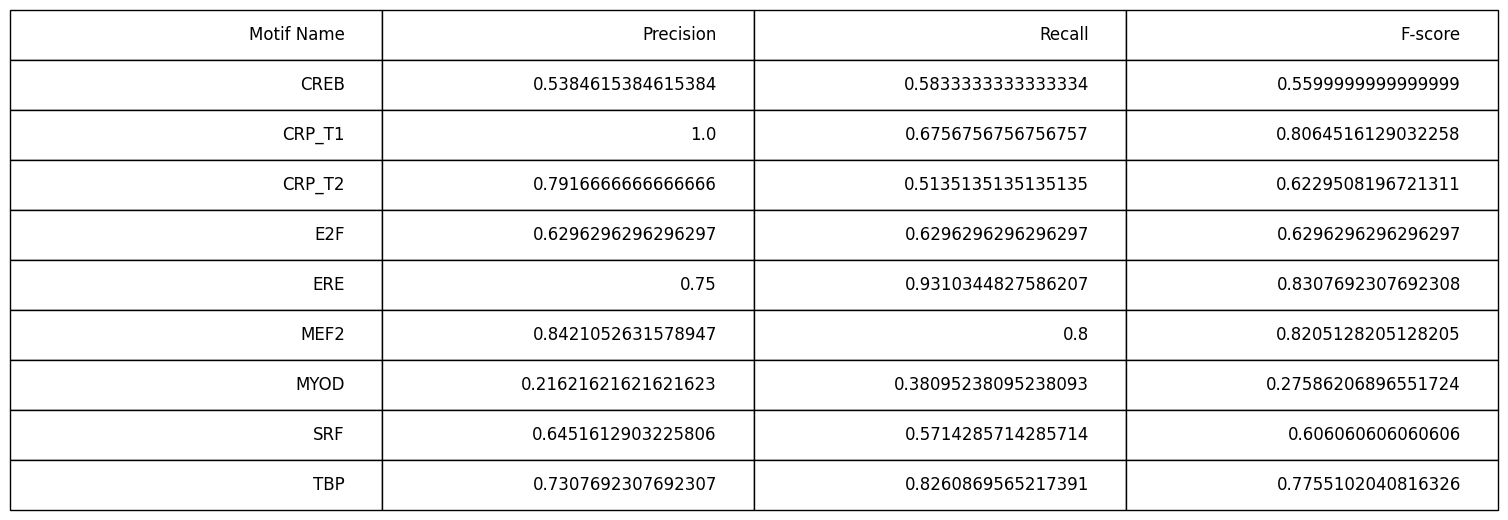

In [55]:
import matplotlib.pyplot as plt
data = [["CREB", 0.5384615384615384, 0.5833333333333334, 0.5599999999999999],
        ["CRP_T1", 1.0, 0.6756756756756757, 0.8064516129032258],
        ["CRP_T2", 0.7916666666666666, 0.5135135135135135, 0.6229508196721311],
        ["E2F", 0.6296296296296297, 0.6296296296296297, 0.6296296296296297],
        ["ERE", 0.75, 0.9310344827586207, 0.8307692307692308],
        ["MEF2", 0.8421052631578947, 0.8, 0.8205128205128205],
        ["MYOD", 0.21621621621621623, 0.38095238095238093, 0.27586206896551724],
        ["SRF", 0.6451612903225806, 0.5714285714285714, 0.606060606060606],
        ["TBP", 0.7307692307692307, 0.8260869565217391, 0.7755102040816326]]
column_names = ['Motif Name', 'Precision', 'Recall', 'F-score']
data.insert(0, column_names)
fig, ax = plt.subplots()
table = ax.table(cellText=data, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(3, 3)
ax.axis('off')
plt.show()